# Strategy V4.1

In this iteration, we aim to use Markov Autoregression Models to predict regime.

In [91]:
from os import wait3

from pandas import DataFrame, Series
from typing import List, Dict, Tuple
from numpy import ndarray

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression

In [92]:
def get_non_stationary_instruments(start_index: int, end_index: int) -> Dict[int, DataFrame]:
	raw_prices: DataFrame = pd.read_csv("../../prices.txt", sep=r"\s+", index_col=None, header=None)
	price_history: ndarray = raw_prices.values[start_index:end_index][:].T
	data: Dict[int, DataFrame] = {}

	for instrument_no in range(0, 50):
		result = adfuller(price_history[instrument_no], autolag="AIC")

		if result[1] > 0.05:
			data[instrument_no] = pd.DataFrame(columns=["price"])
			data[instrument_no]["price"] = price_history[instrument_no]

	return data


def implement_returns(data: Dict[int, DataFrame]) -> Dict[int, DataFrame]:
	for instrument_no in data:
		data[instrument_no]["returns"] = data[instrument_no]["price"].diff().dropna()

		# Clip the data
		data[instrument_no] = data[instrument_no].iloc[1:].reset_index(drop=True)

	return data

### Fit Markov Autoregression Model

In [93]:
import pickle

def fit_markov_autoregression(data: Dict[int, DataFrame]) -> Tuple[Dict[int, DataFrame],
Dict[int, any]]:
	models: Dict[int, any] = {}

	for instrument_no in data:
		# Fit the model using returns
		model = MarkovAutoregression(data[instrument_no]["returns"], k_regimes=2, order=1,
			switching_ar=False)
		results = model.fit()
		data[instrument_no]["predicted_regime"] = pd.Series(np.argmax(results
		.filtered_marginal_probabilities , axis=1))
		models[instrument_no] = results
		
		with open(f"models/instrument_{instrument_no}_model.pkl", "wb") as file:
			pickle.dump(results,file)
		
		file.close()

	return data, models


def plot_price_and_regime(data: Dict[int, DataFrame]) -> None:
	for instrument_no in data:
		dates: Series = data[instrument_no].index
		prices: Series = data[instrument_no]["price"]
		regimes: Series = data[instrument_no]["predicted_regime"]
		regime_states: Dict[int, str] = {0: "Uptrend", 1: "Downtrend"}

		# Price plot
		# build a DataFrame to detect regime‐change segments
		df = pd.DataFrame({'price': prices, 'regime': regimes}, index=dates)
		# each time regime != previous, start a new segment
		df['segment'] = (df['regime'] != df['regime'].shift()).cumsum()

		fig, (ax_price, ax_regime) = plt.subplots(
			nrows=2, ncols=1, sharex=True, figsize=(16, 4),
			gridspec_kw={'height_ratios': [3, 1]}
		)

		# plot each segment in its color
		for _, seg in df.groupby('segment'):
			color = "red" if seg['regime'].iloc[0] == 1 else "green"
			ax_price.plot(seg.index, seg['price'], color=color, lw=1.5)

		ax_price.set_title(f"Instrument {instrument_no} Price and Regime")
		ax_price.set_ylabel("Price")
		ax_price.grid(alpha=0.3)

		# regime step‐plot
		ax_regime.step(df.index, df['regime'], where='post')
		ax_regime.set_ylabel("Regime")
		ax_regime.set_yticks(list(regime_states.keys()))
		ax_regime.set_yticklabels([regime_states[k] for k in regime_states])
		ax_regime.set_ylim(-0.1, len(regime_states) - 0.9)
		ax_regime.grid(alpha=0.3)

		ax_regime.set_xlabel('Date')
		fig.autofmt_xdate()
		plt.tight_layout()
		plt.show()

### Identifying which Regime Gives an Uptrend or a Downtrend

With an Markov AutoRegression Model, it can be seen that it outputs 2 states and doesn't 
automatically identify which ones are uptrends and which are downtrends.

We need to build a function to be able to differentiate these two states.

In [94]:
is_zero_uptrend: Dict[int, bool] = {
	0: True,
	1: True,
	2: True,
	3: False,
	4: True,
	5: True,
	6: True,
	7: False,
	8: True,
	9: True,
	10: False,
	11: False,
	12: False,
	13: False,
	14: False,
	15: False,
	16: True,
	17: False,
	19: True,
	20: True,
	21: False,
	22: False,
	23: False,
	24: False,
	25: True,
	27: True,
	28: False,
	29: False,
	30:True,
	31: False,
	32: False,
	34: False,
	35: True,
	36: False,
	38: False,
	39: False,
	40: False,
	41: False,
	42: False,
	43: True,
	44: False,
	45: False,
	46: True,
	47: True,
	48: False,
	49: False,
}

def generate_signals(data: Dict[int, DataFrame]) -> Dict[int, DataFrame]:
	for instrument_no in data:
		regimes: Series = data[instrument_no]["predicted_regime"]

		# Uptrend
		if is_zero_uptrend[instrument_no]: 
			data[instrument_no]["signal"] = np.where(regimes == 0, 1, -1)
		# Downtrend
		else:
			data[instrument_no]["signal"] = np.where(regimes == 1, 1, -1)

	return data



### Backtesting and Measuring Performance

In [95]:
def get_strategy_results(data: Dict[int, DataFrame]) -> Dict[int, DataFrame]:
	for instrument_no in data:
		# Get Log Returns
		data[instrument_no]["log_return"] = np.log(data[instrument_no]
		["price"]).diff().shift(-1)
		# Get Strategy Return
		data[instrument_no]["strategy_return"] = (data[instrument_no]["signal"]
												  * data[instrument_no]["log_return"])

		# Get Position changes
		position_change: ndarray = data[instrument_no]["signal"].diff().abs()

		# Apply the commission fee
		data[instrument_no]["strategy_return"] -= position_change * 0.0005

	return data


def show_performance_metrics(data: Dict[int, DataFrame]) -> None:
	performance_metrics: Dict[str, List[int | float]] = {}
	performance_metrics["Instrument No."] = list(data.keys())
	performance_metrics["Profit Factor"] = []
	performance_metrics["Sharpe Ratio"] = []

	for instrument_no in data:
		# Get Returns
		returns: Series = data[instrument_no]["strategy_return"]

		# Compute performance metrics
		profit_factor = returns[returns > 0].sum() / returns[returns < 0].abs().sum()
		sharpe = (returns.mean() / returns.std()) * (252 ** 0.5)

		performance_metrics["Profit Factor"].append(profit_factor)
		performance_metrics["Sharpe Ratio"].append(sharpe)

	performance_metrics_df: DataFrame = pd.DataFrame(performance_metrics)
	print(performance_metrics_df.to_string(index=False))

 Instrument No.  Profit Factor  Sharpe Ratio
              0      92.072482     18.004551
              1       1.142732      0.849276
              2     729.906790     20.670288
              3     798.457110     19.637569
              4     114.820423     17.874353
              5      78.111446     18.885888
              6     399.373219     19.516123
              7     165.752947     19.037658
              8    1013.050115     20.990871
              9     483.520183     18.808577
             10     126.721907     18.719881
             11     320.366224     19.599288
             12     459.232187     19.760018
             13      96.860335     18.774814
             14     204.215268     20.239074
             15      75.139259     17.179074
             16     581.481959     20.135083
             17     357.187277     20.203297
             19      93.721025     17.929940
             20      84.502817     18.855540
             21     349.510006     19.916983
          

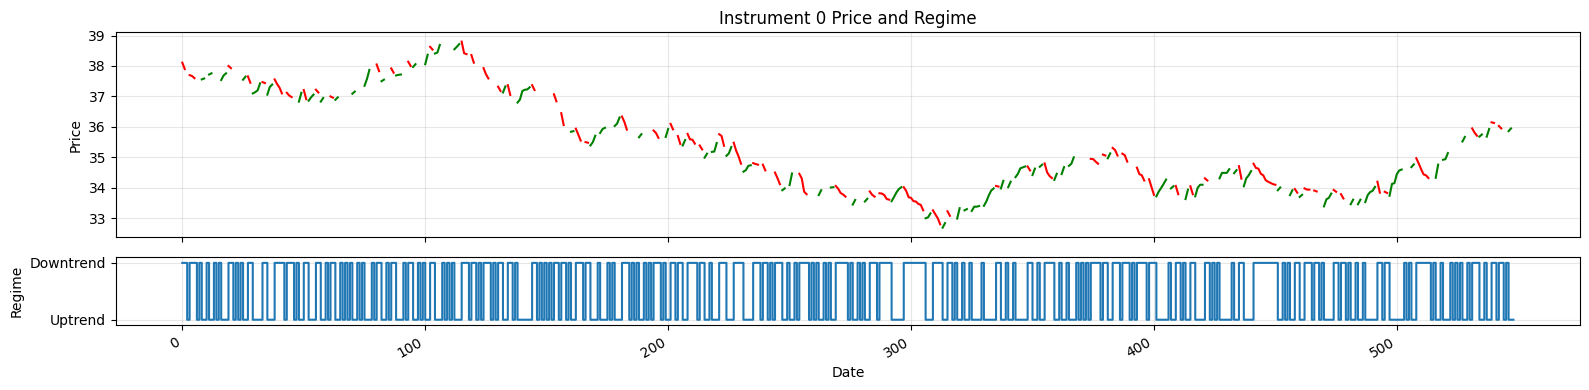

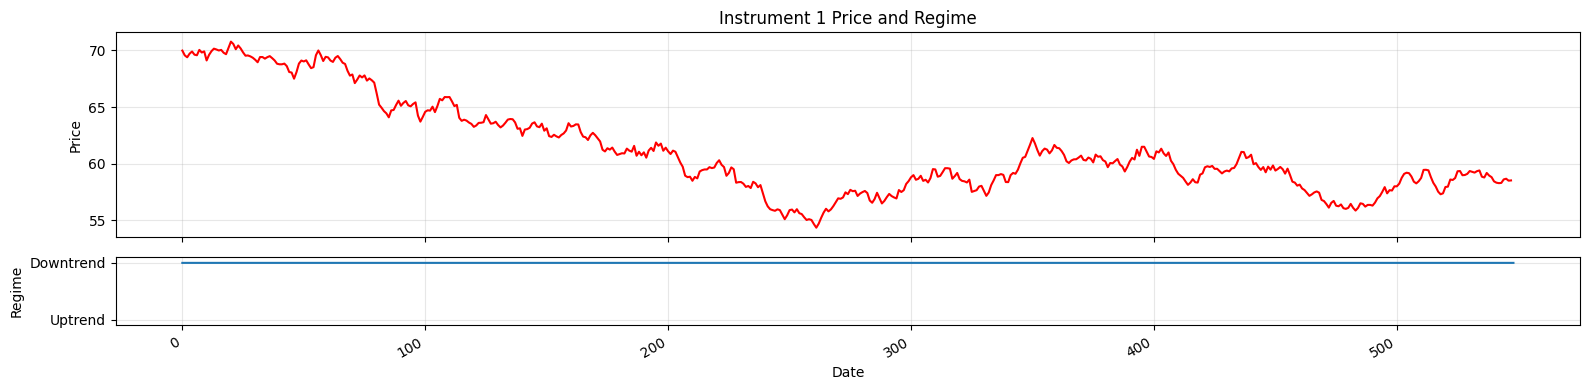

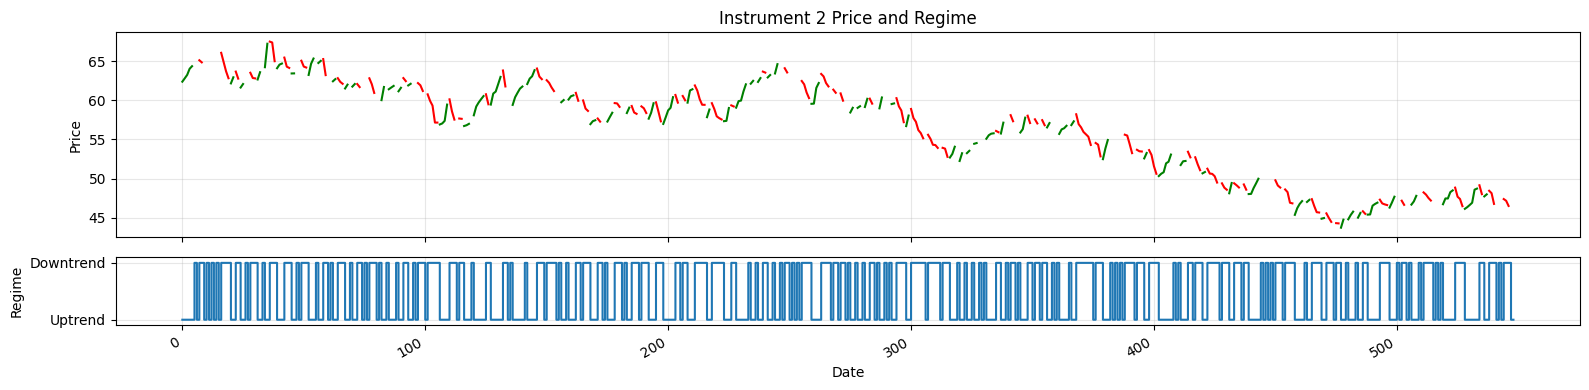

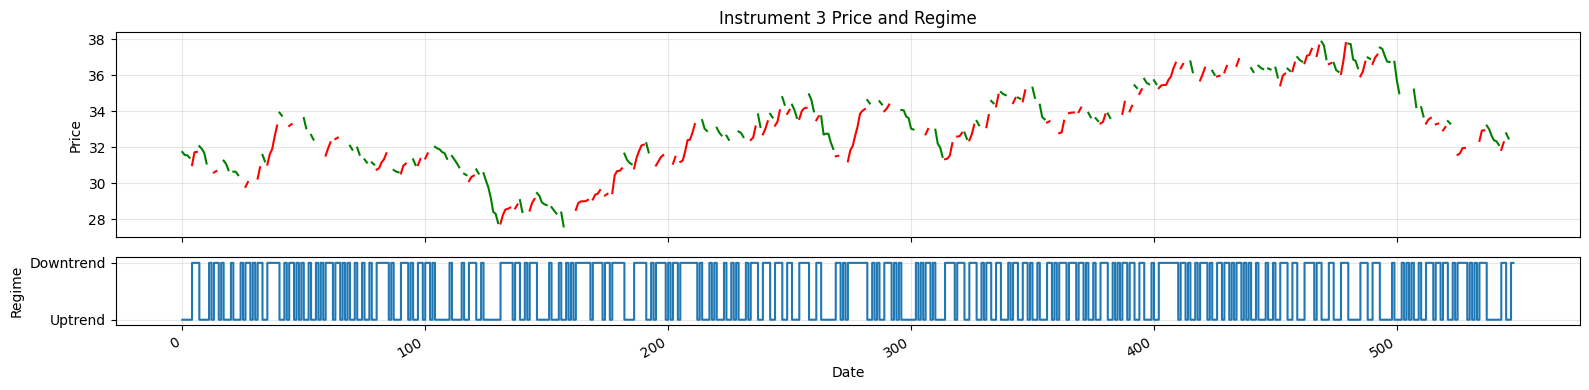

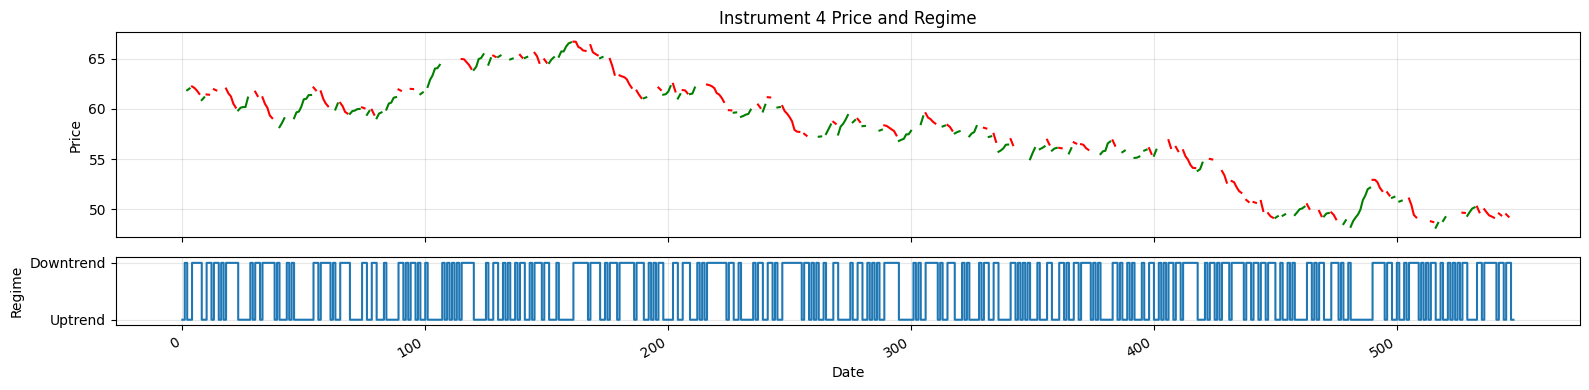

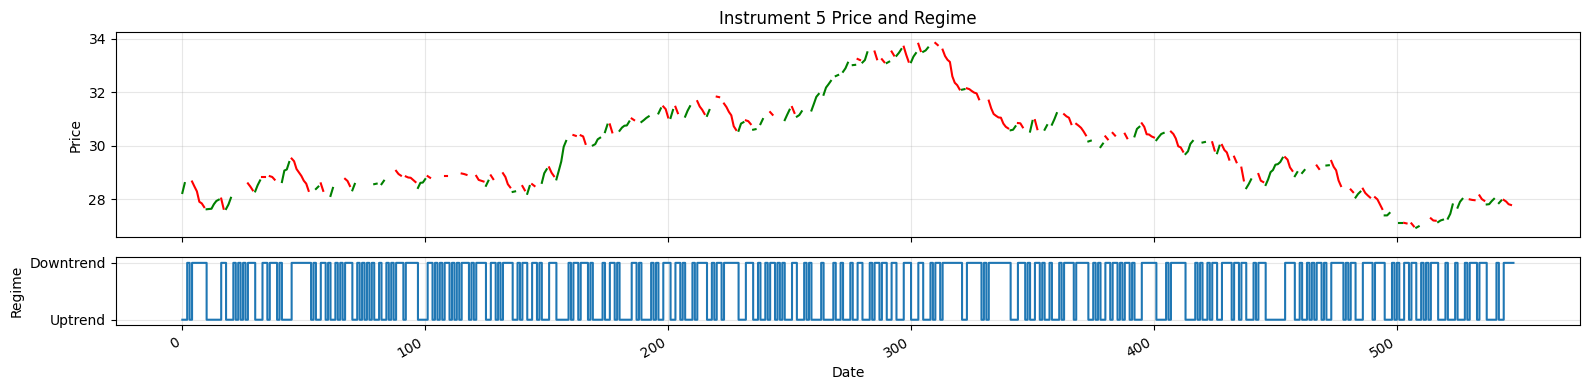

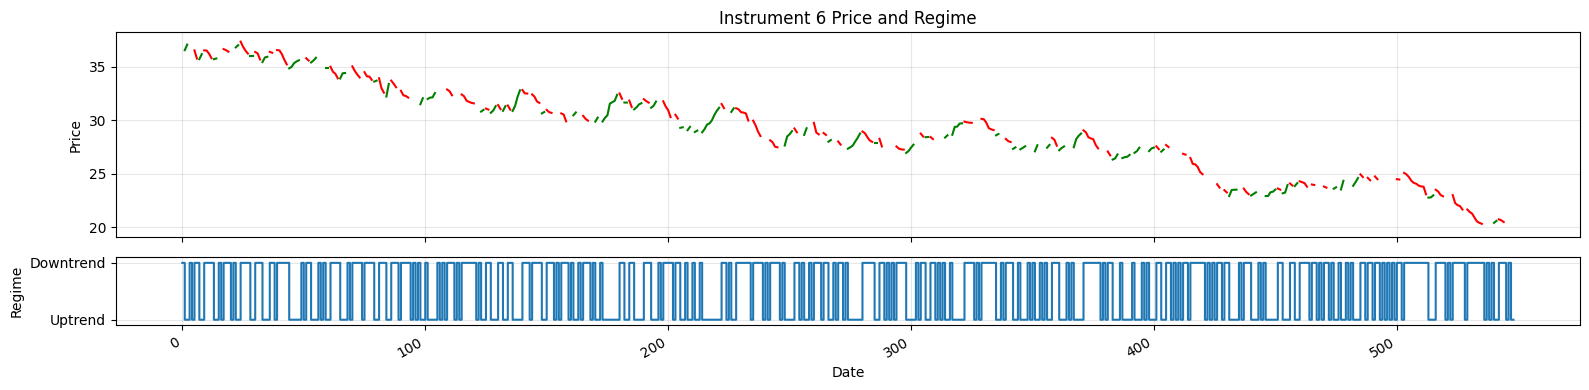

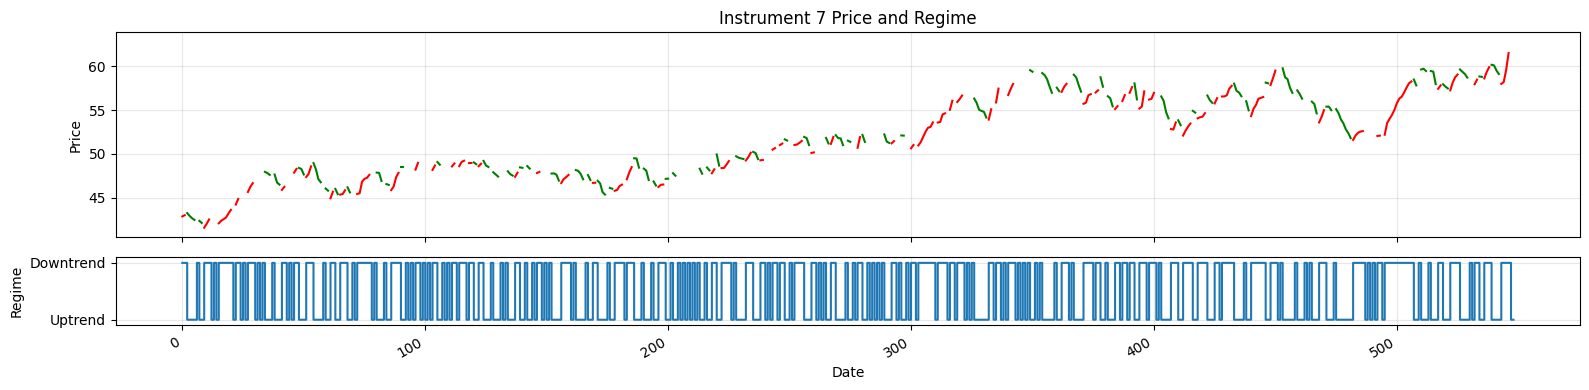

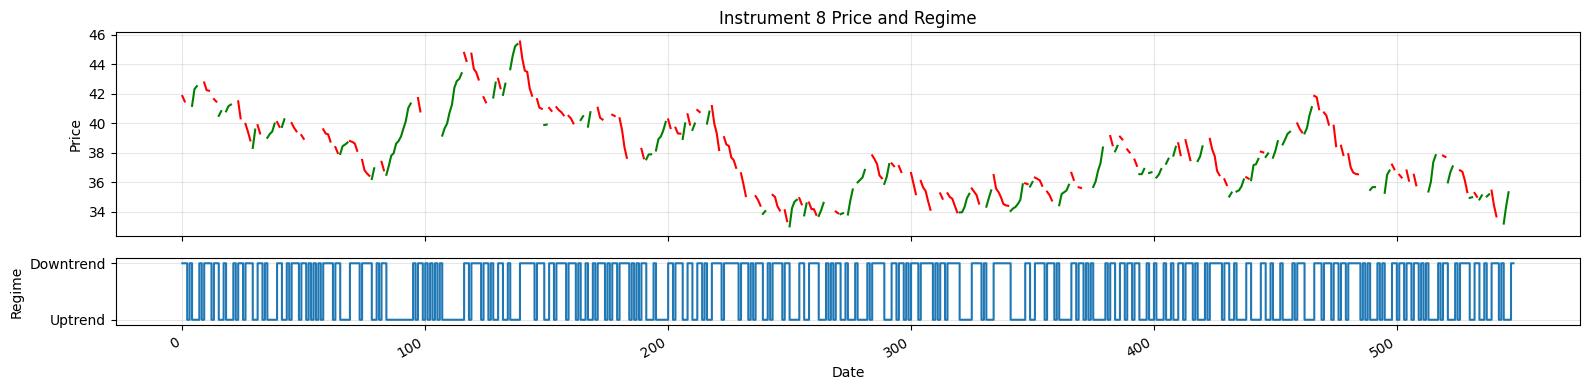

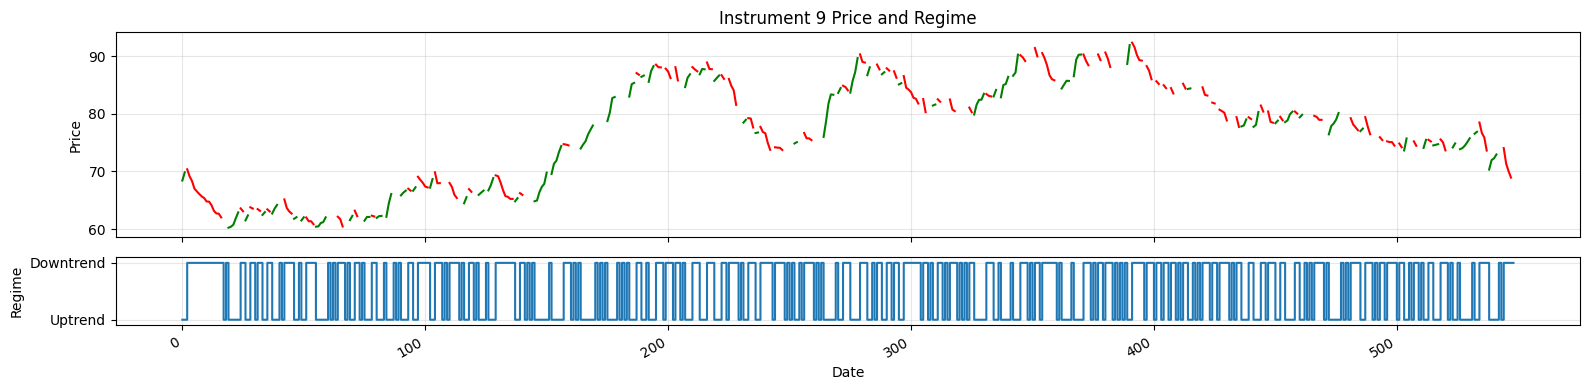

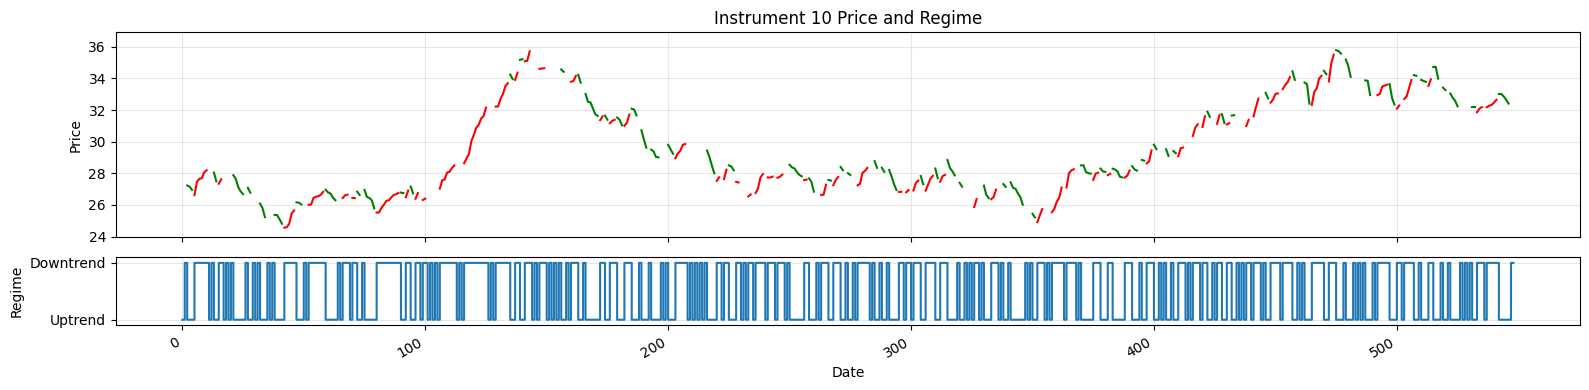

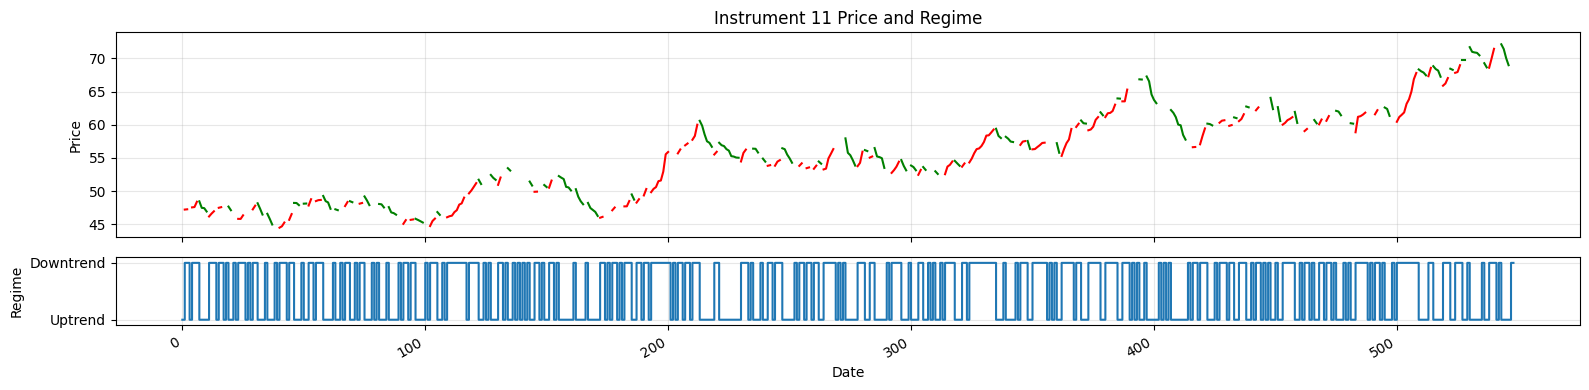

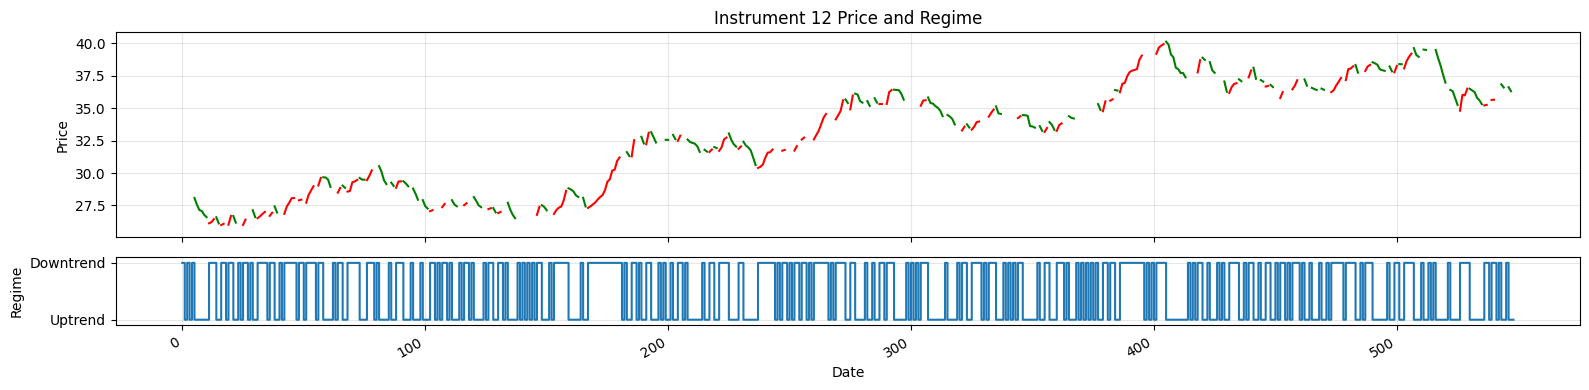

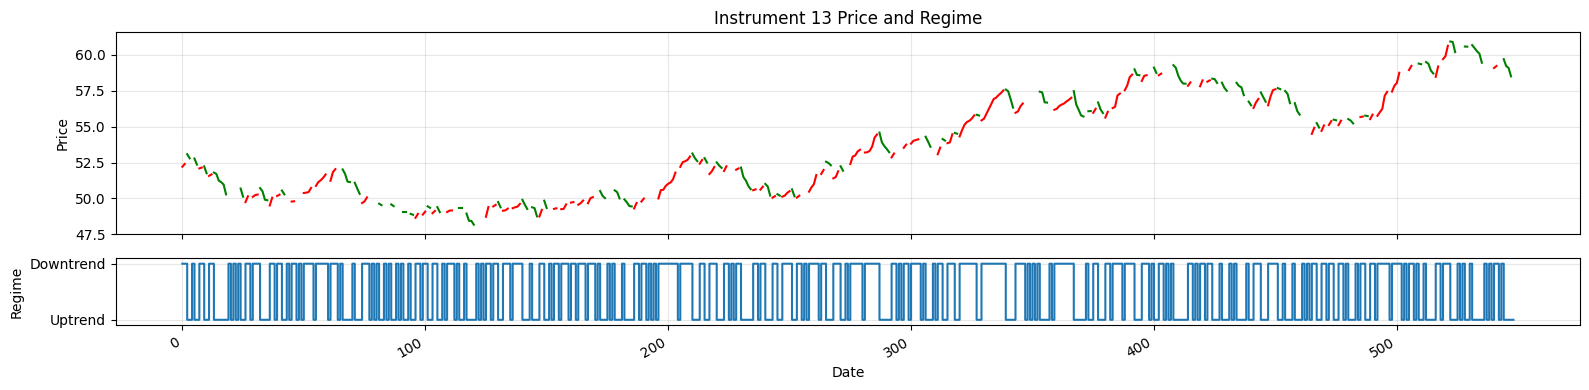

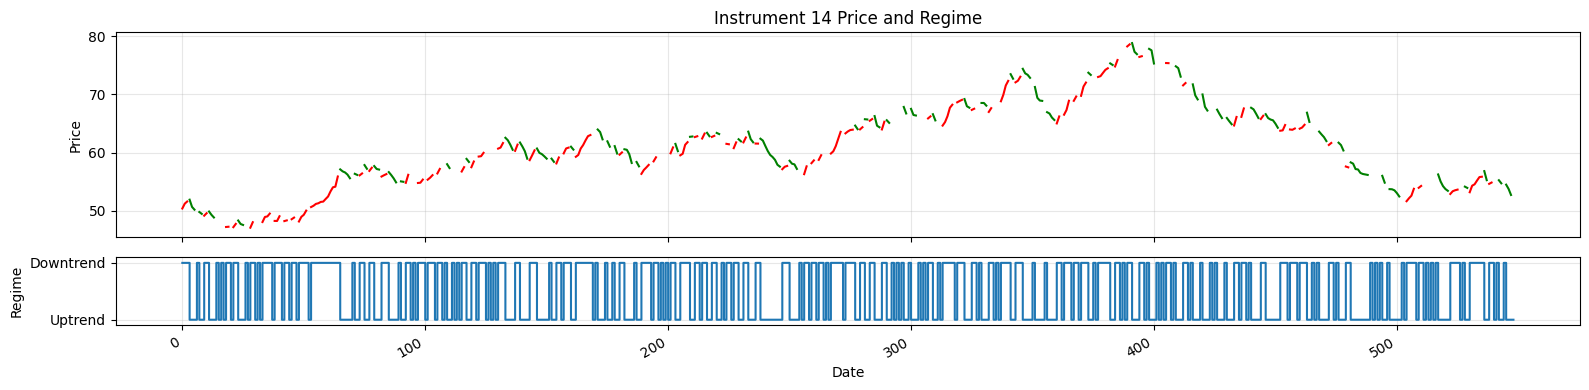

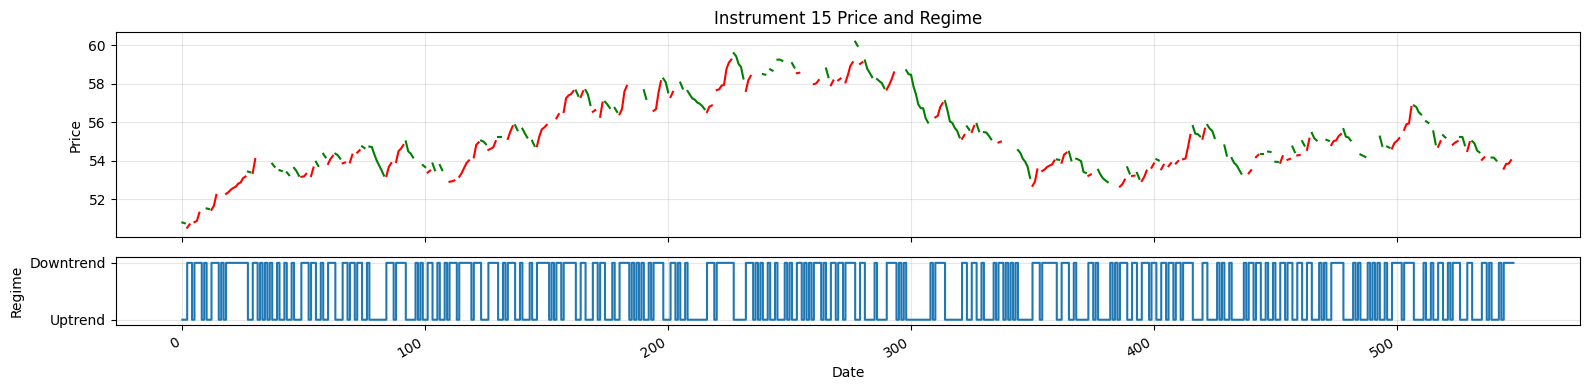

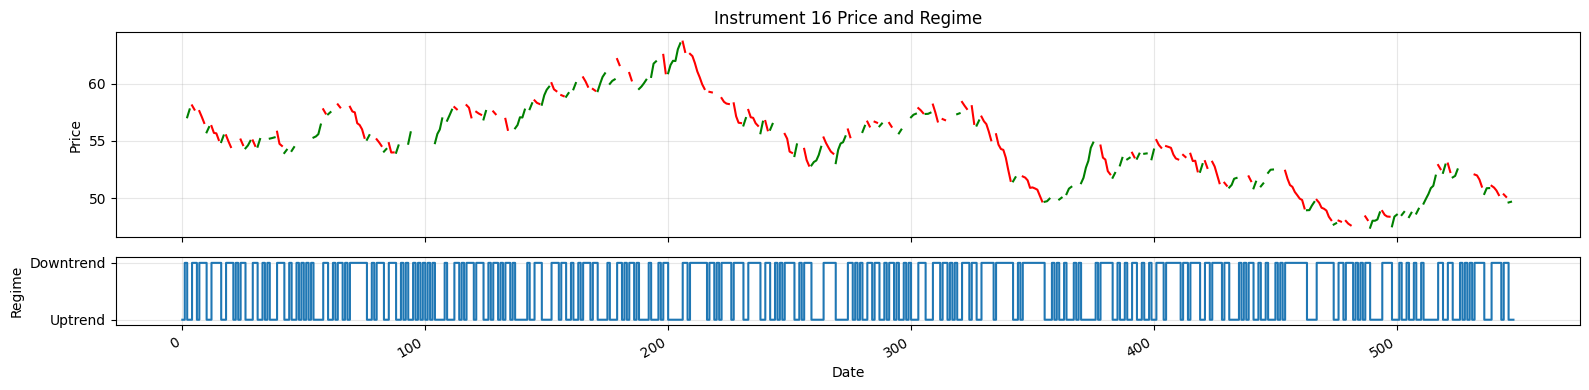

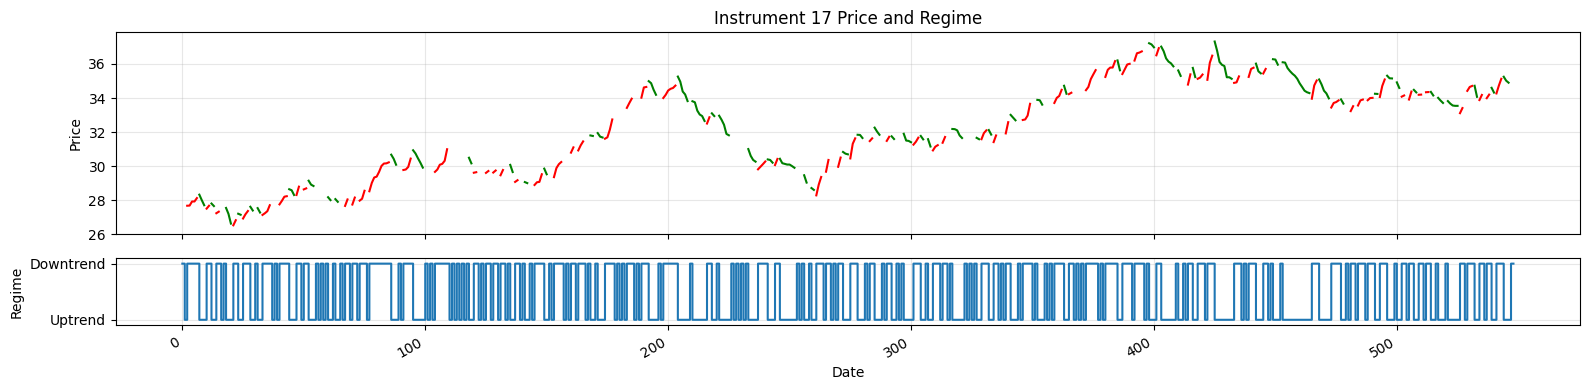

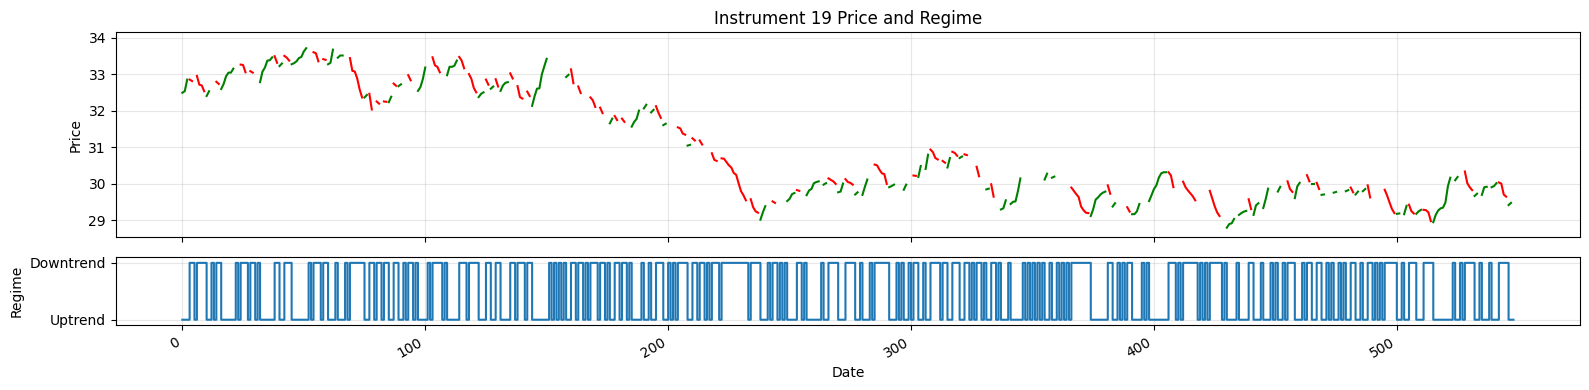

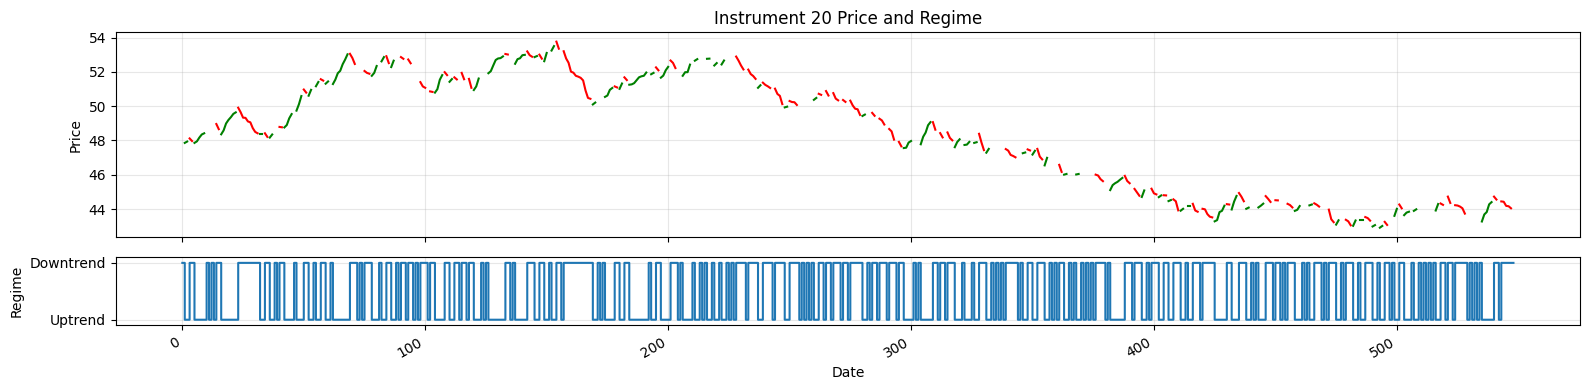

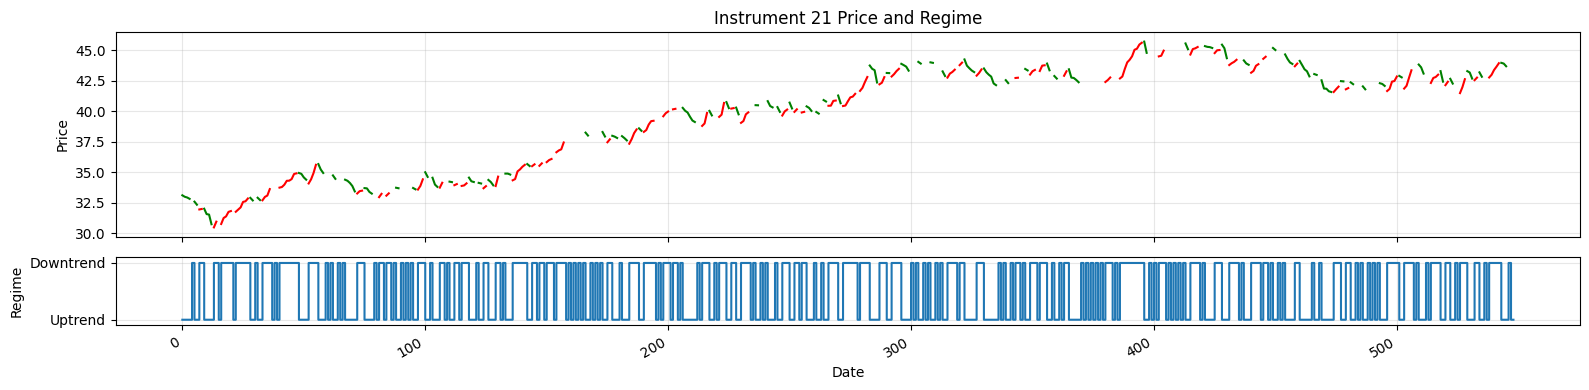

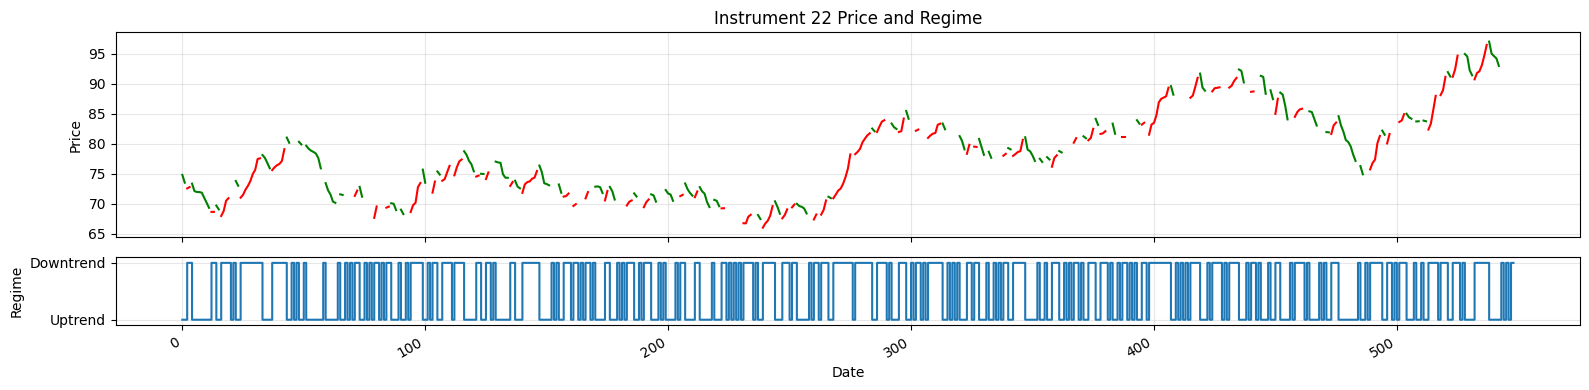

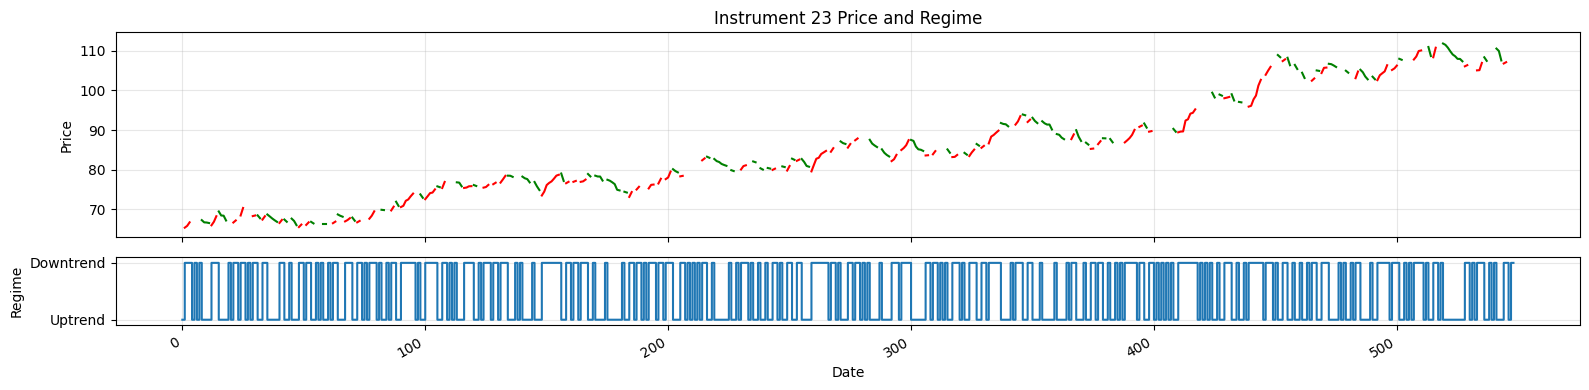

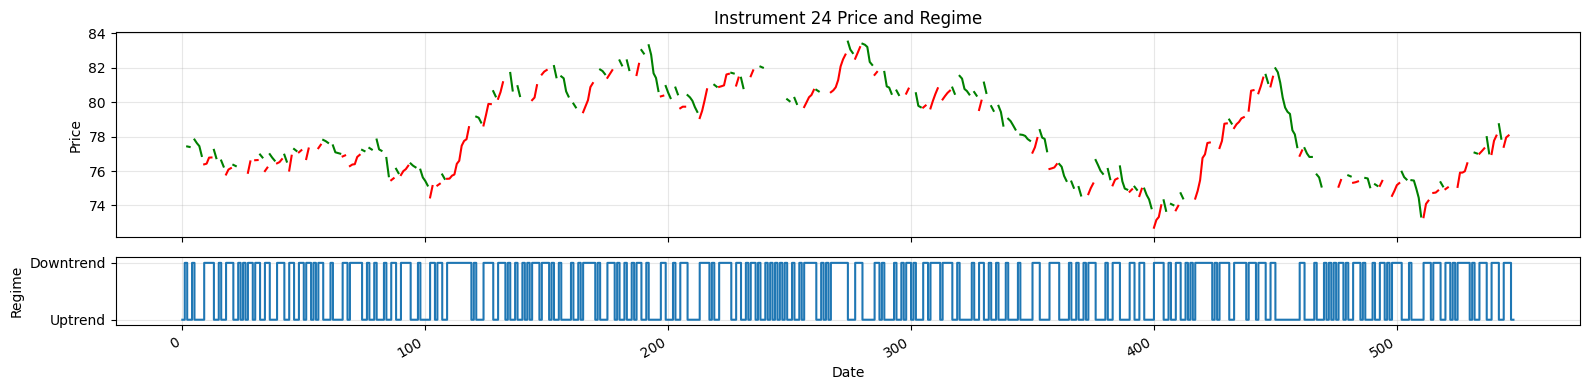

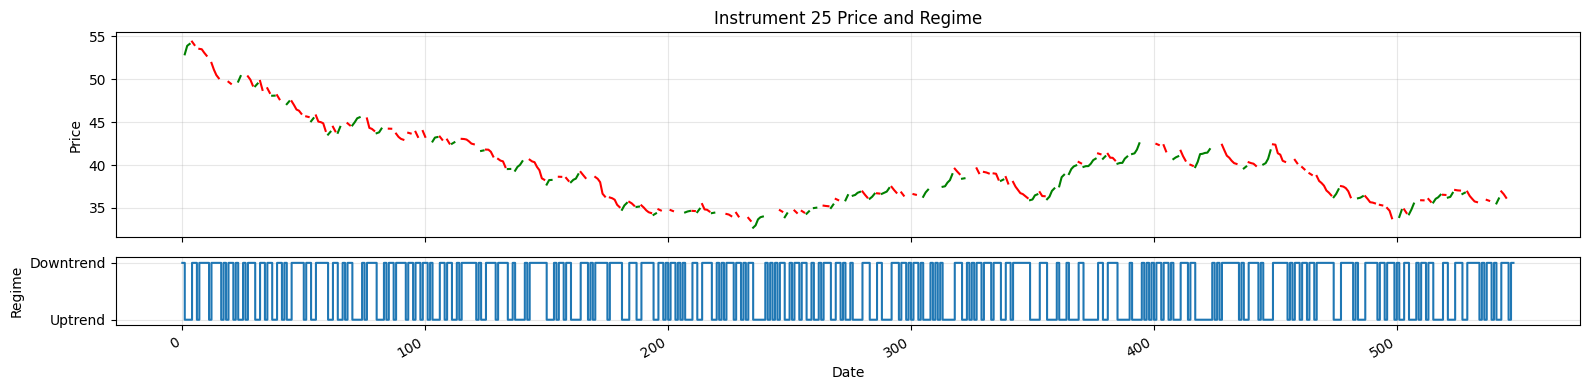

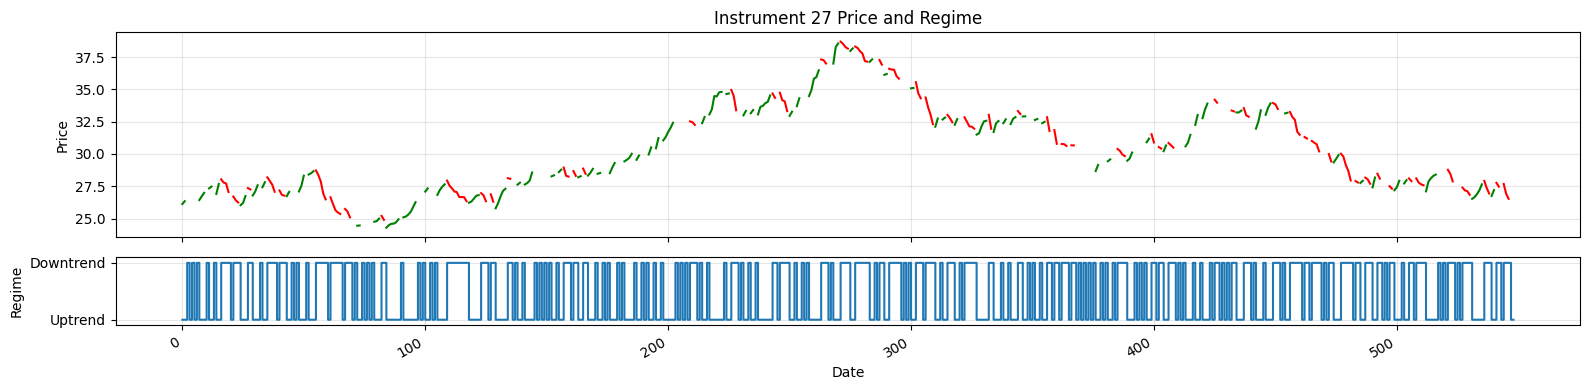

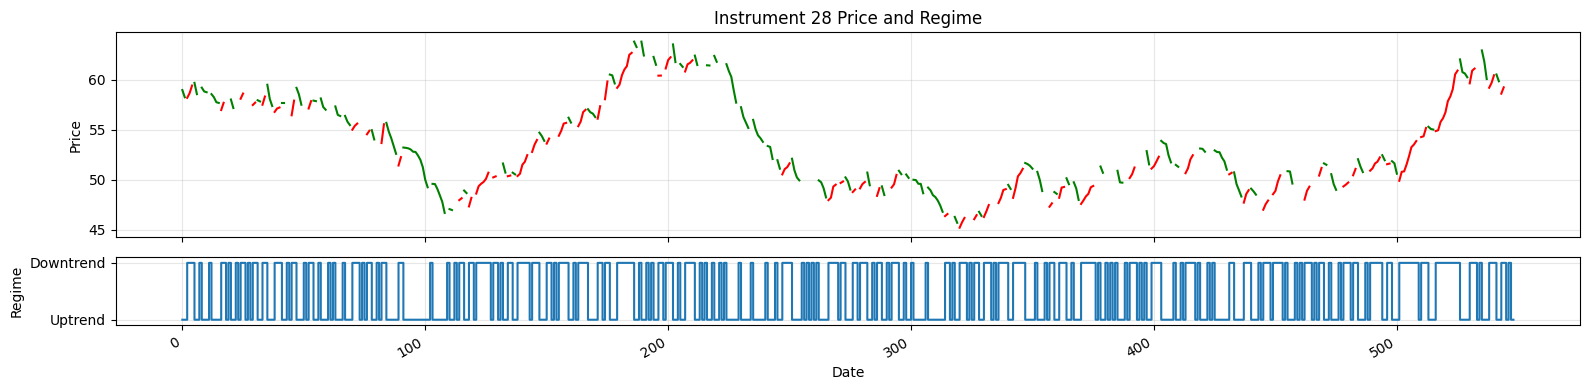

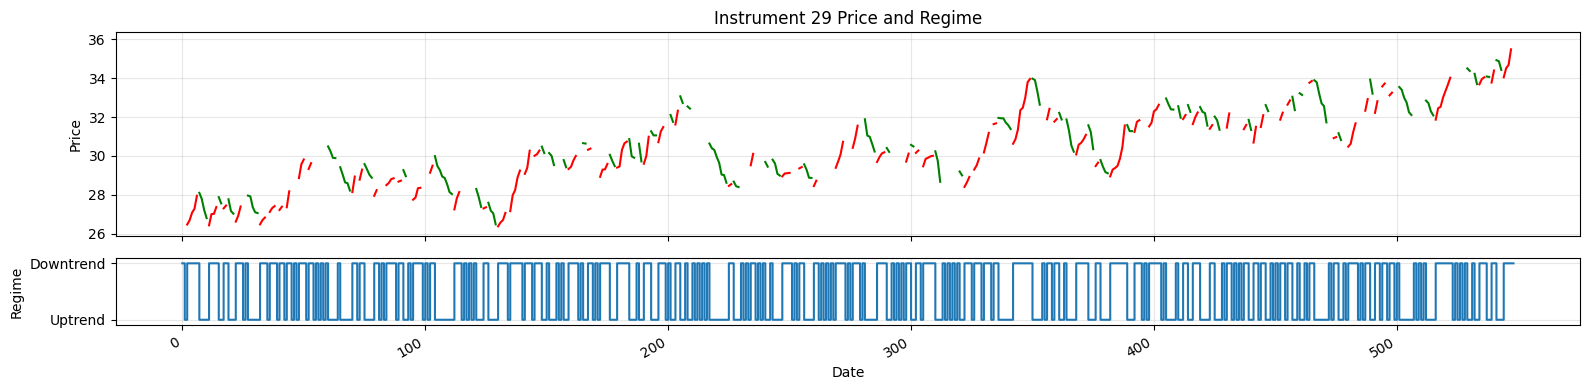

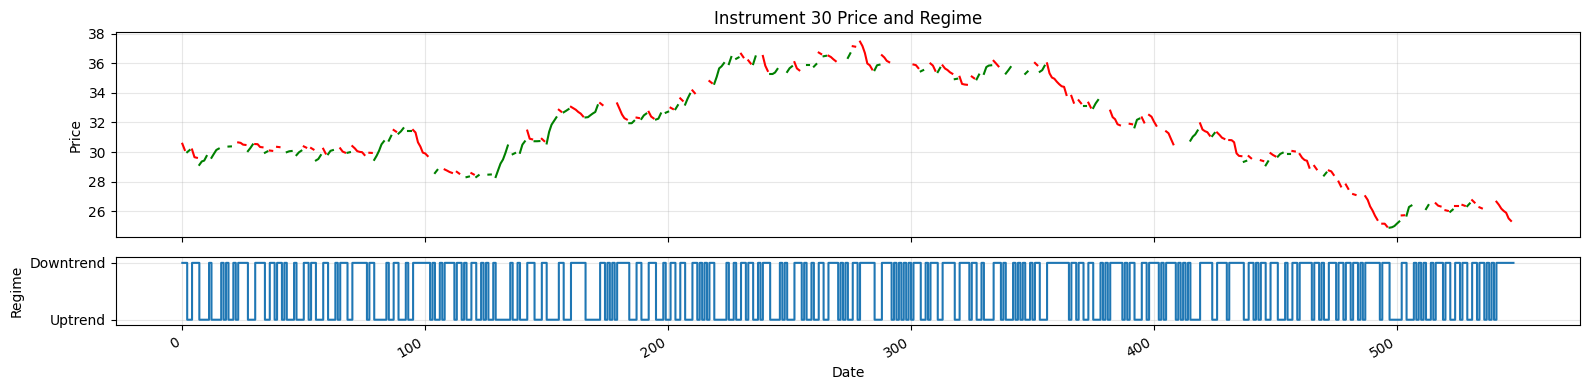

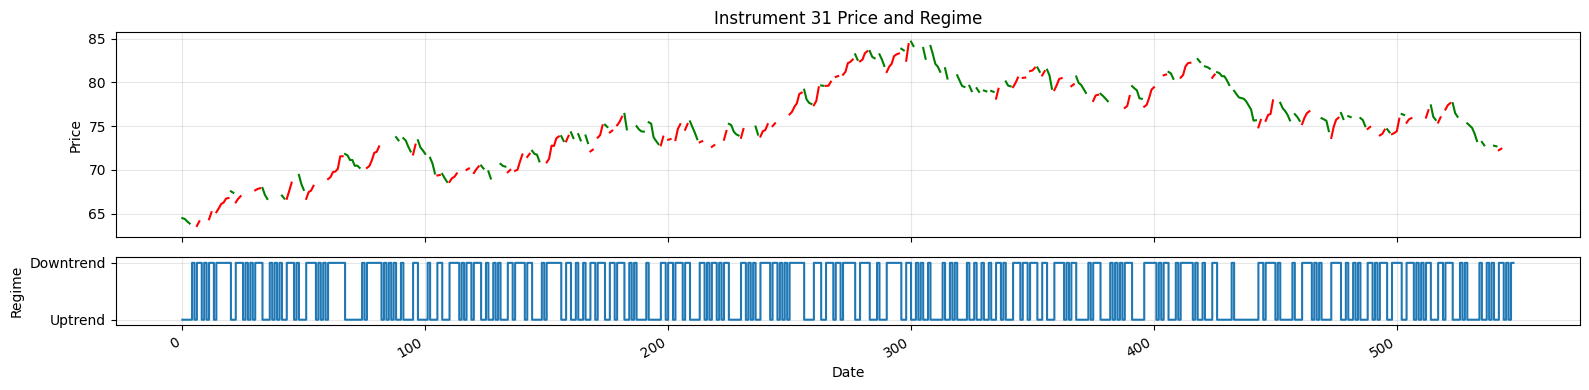

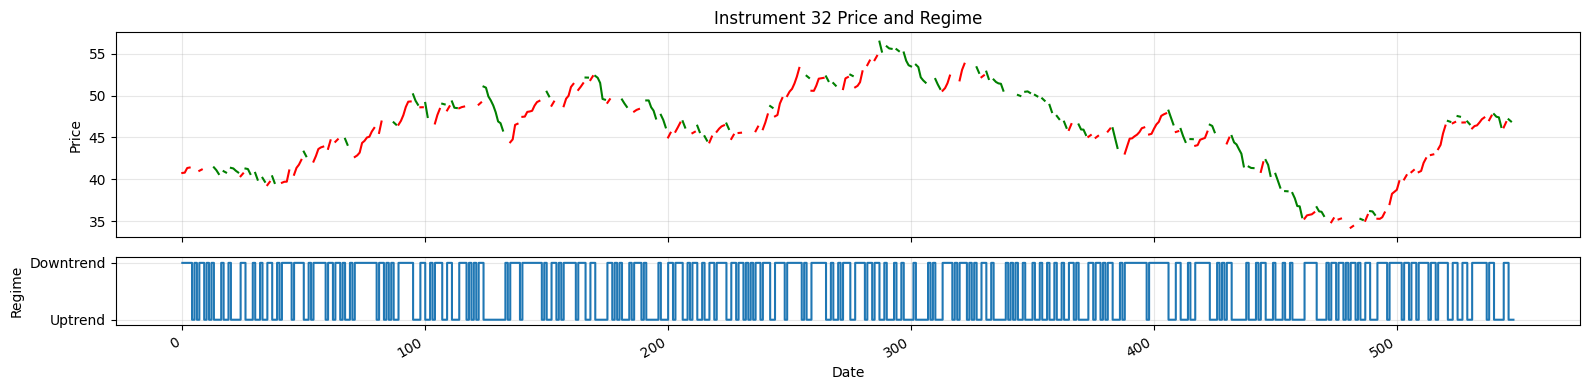

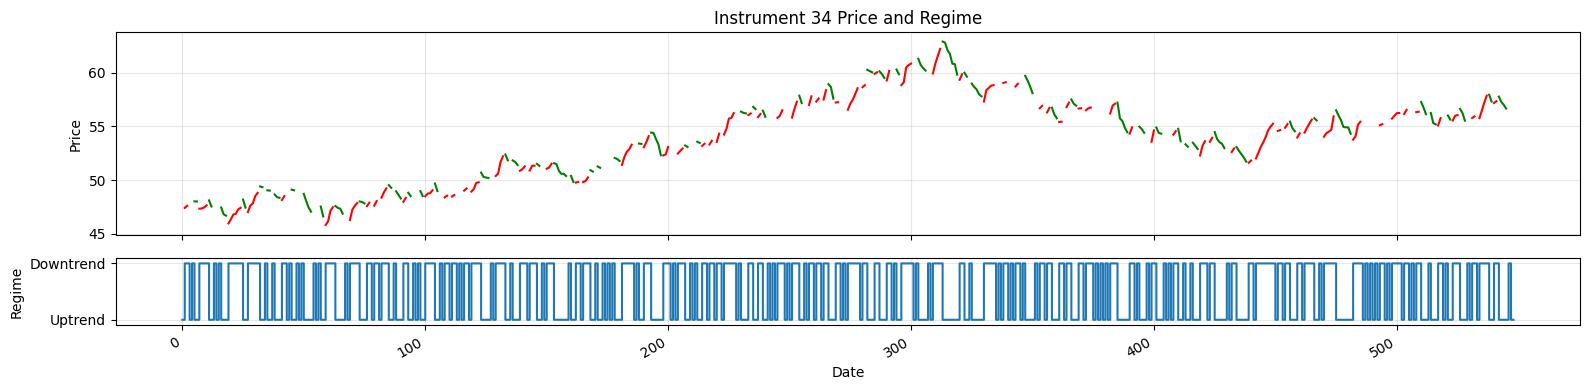

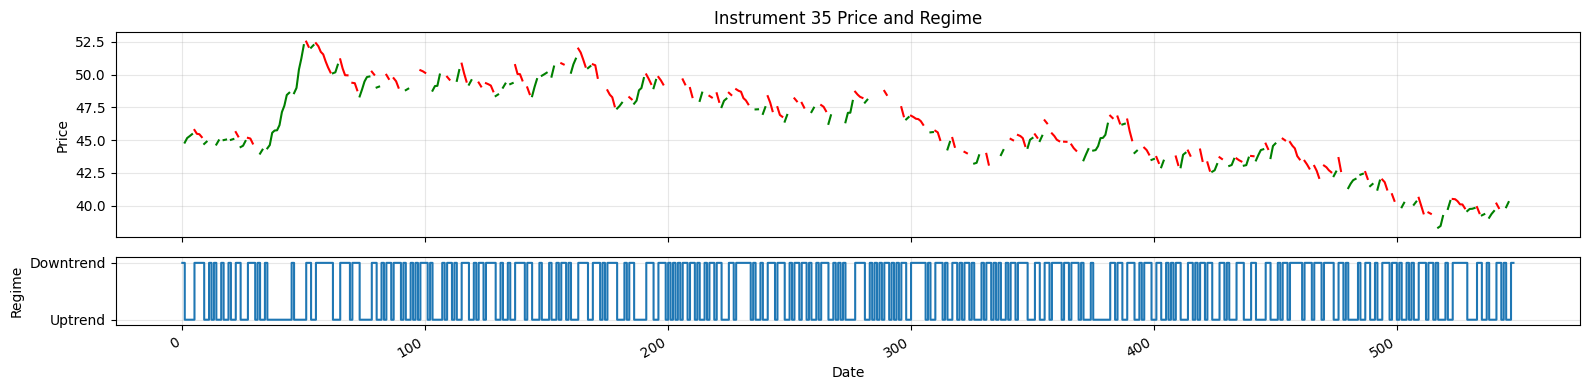

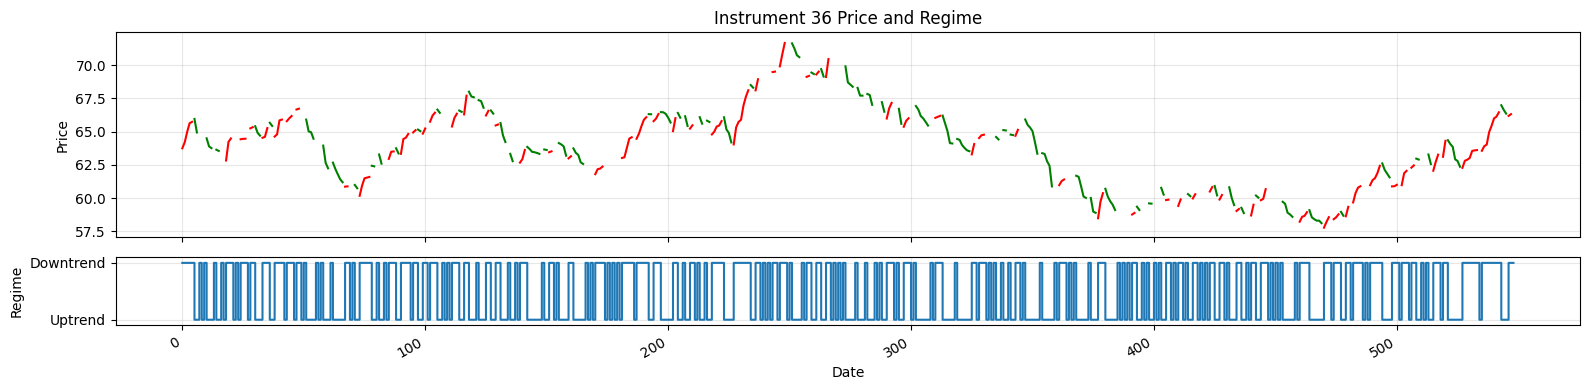

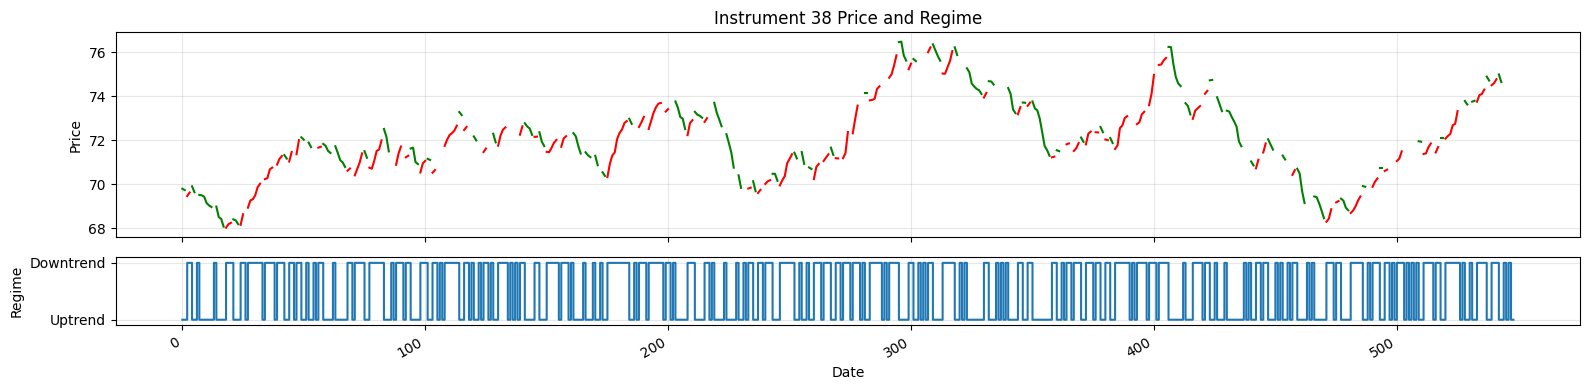

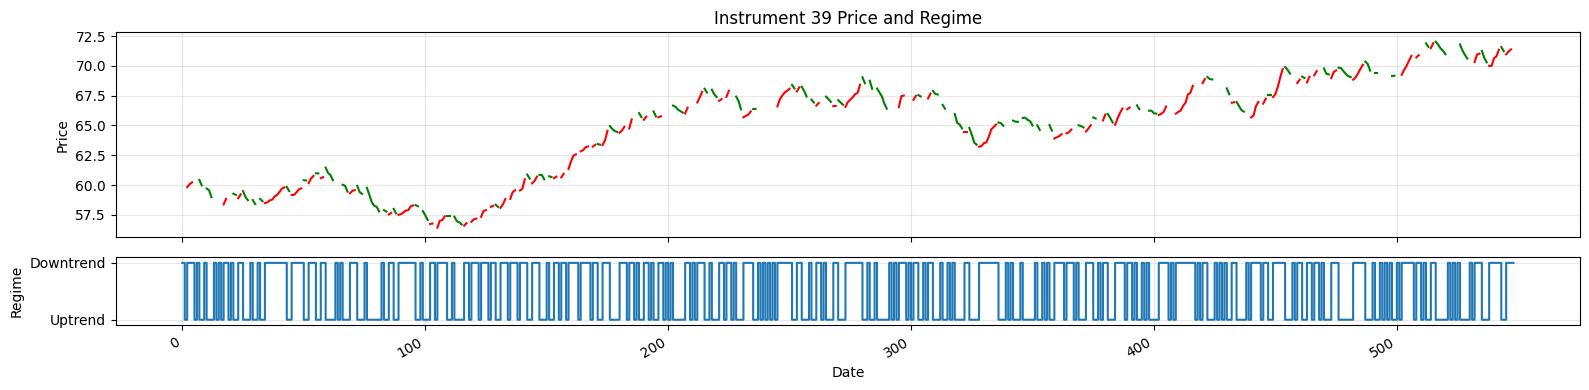

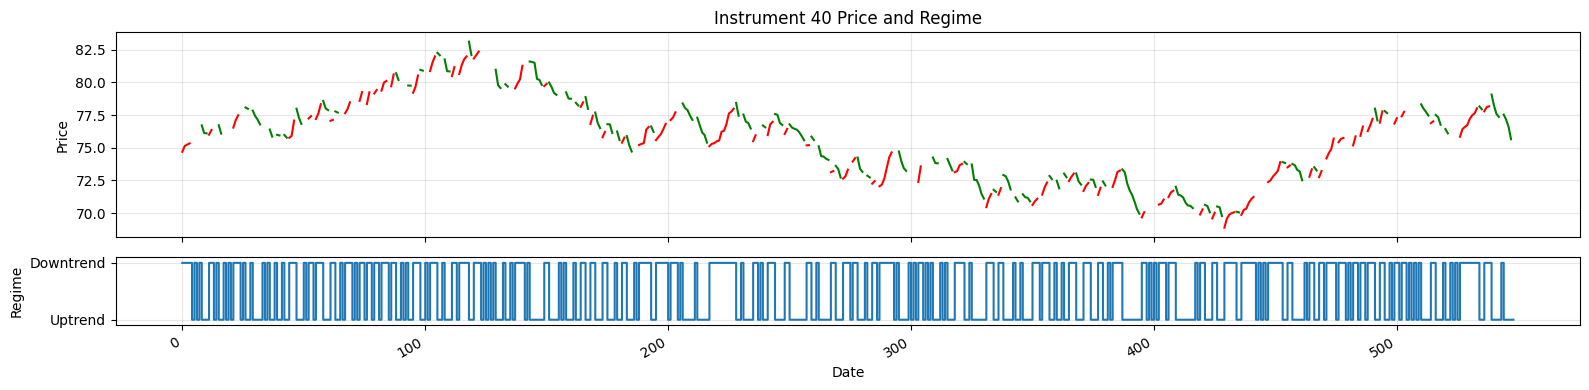

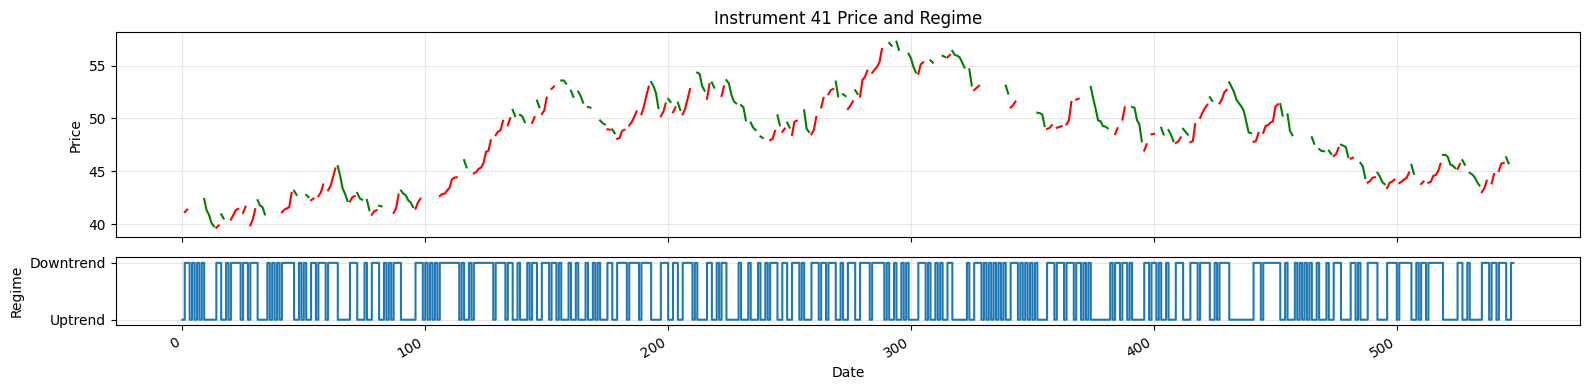

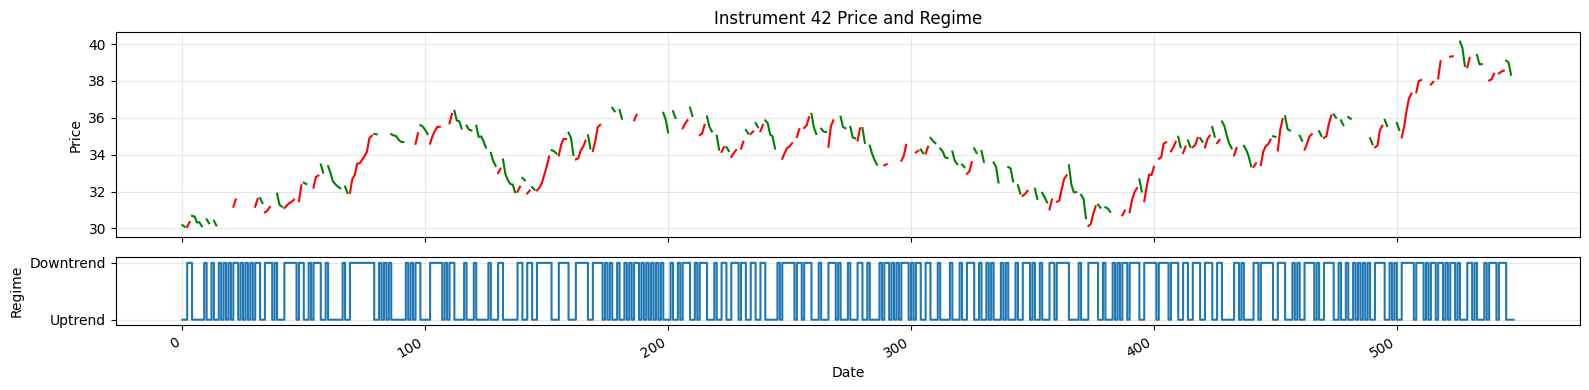

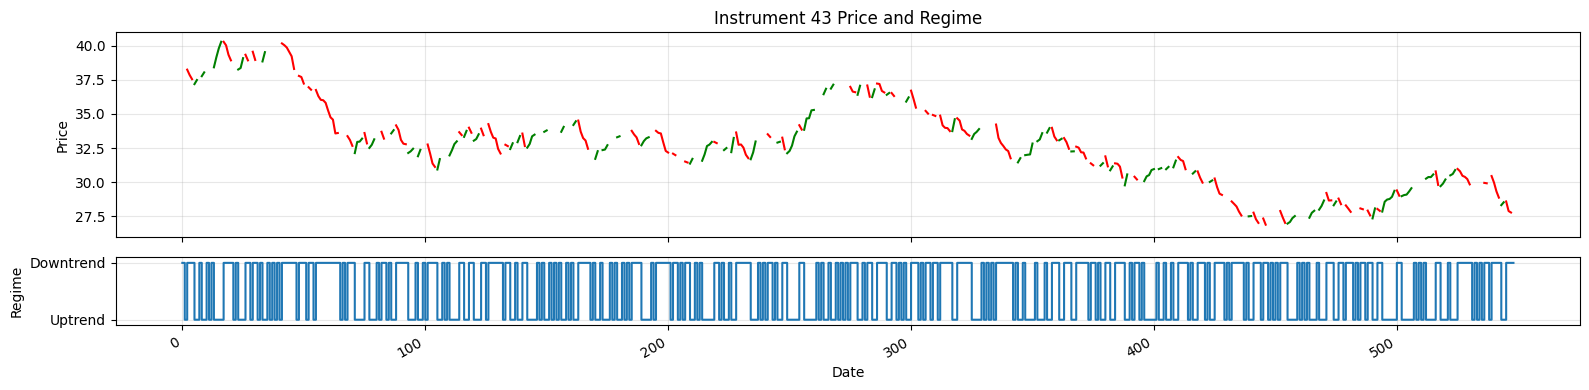

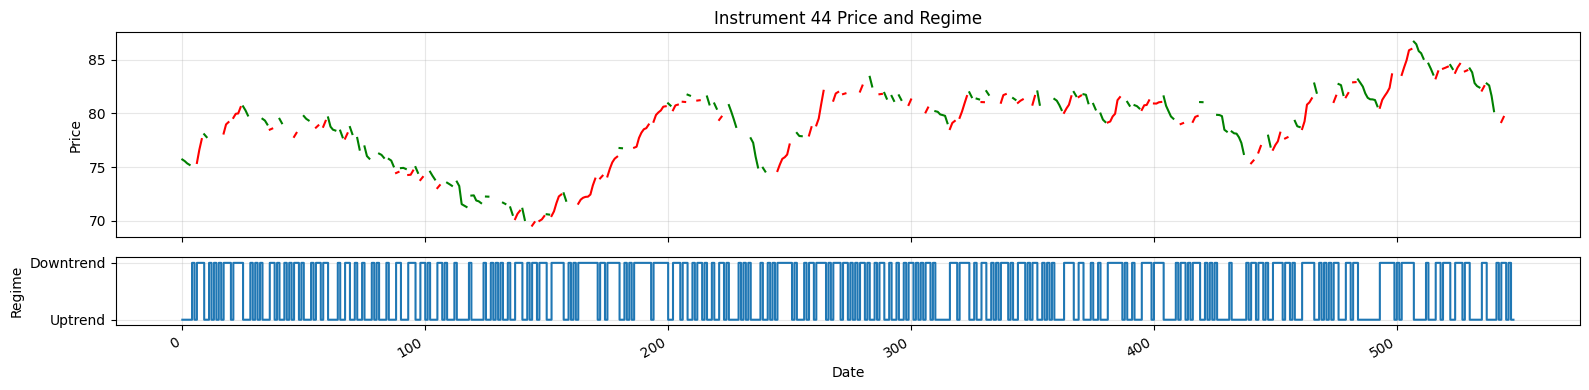

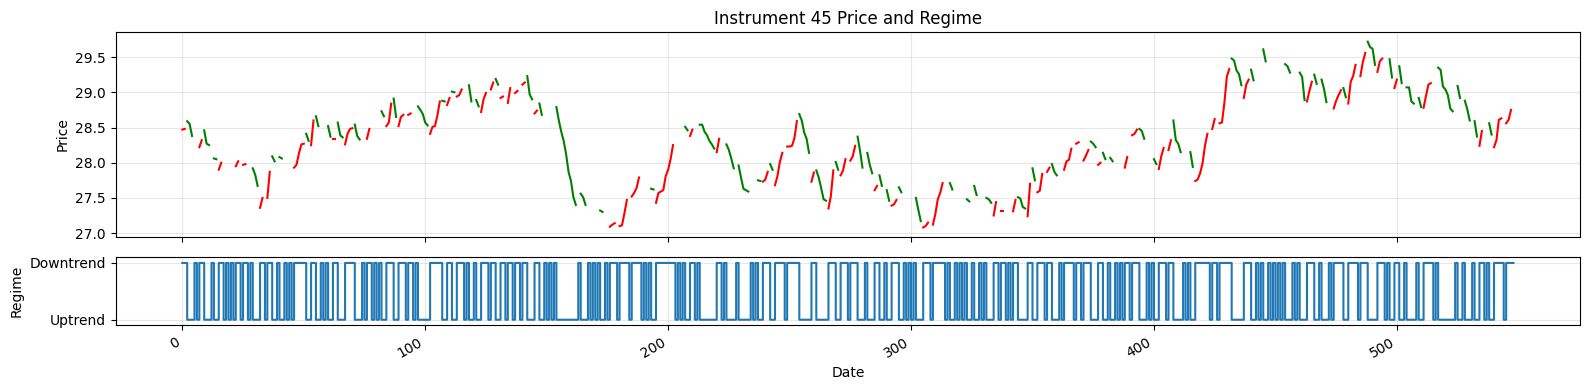

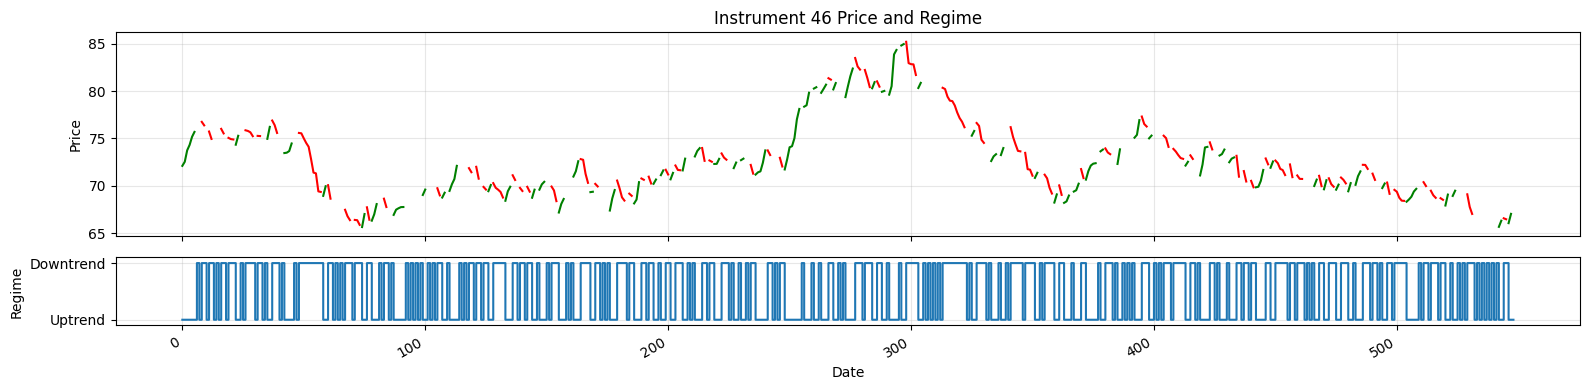

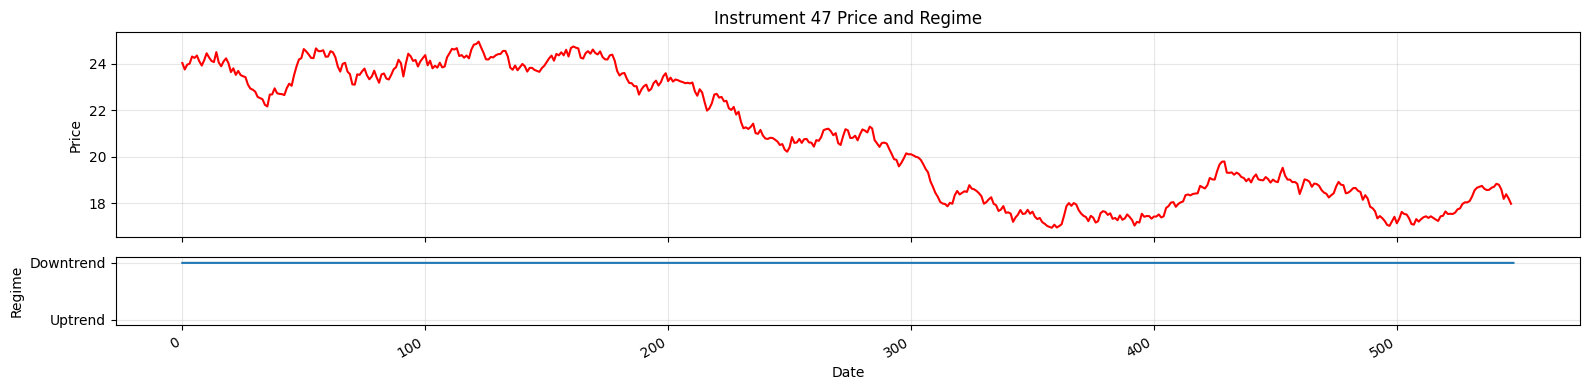

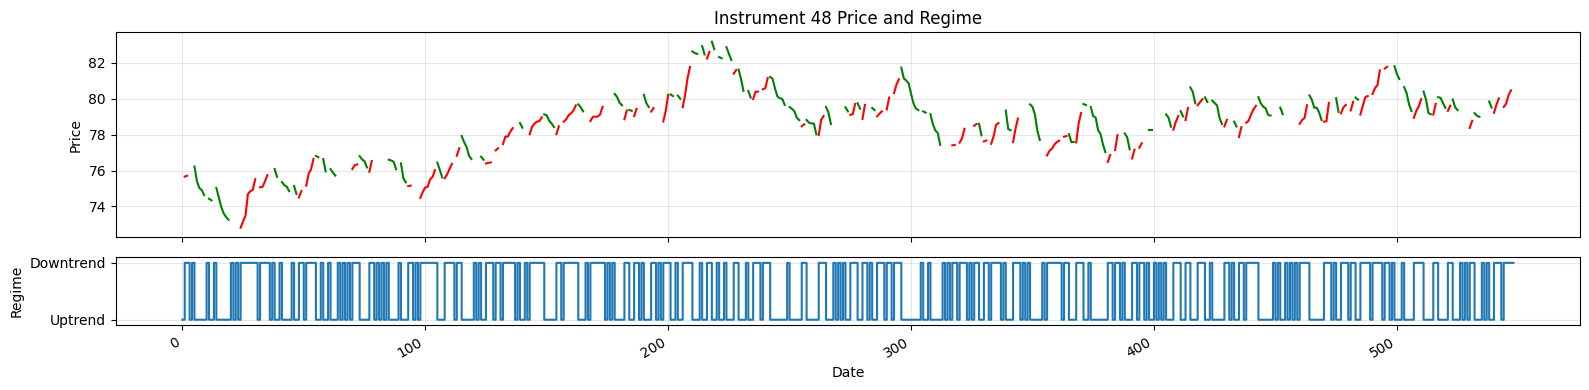

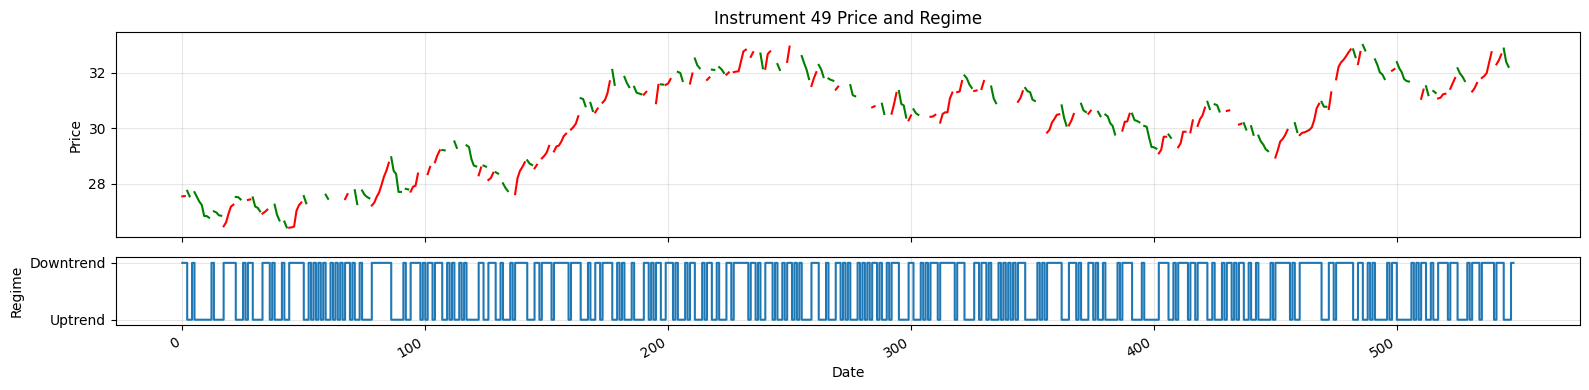

In [96]:
sample_data: Dict[int, DataFrame] = get_non_stationary_instruments(0, 550)
sample_data = implement_returns(sample_data)
sample_data, models = fit_markov_autoregression(sample_data)
sample_data = generate_signals(sample_data)
sample_data = get_strategy_results(sample_data)
show_performance_metrics(sample_data)
plot_price_and_regime(sample_data)

### Testing out of sample performance

 Instrument No.  Profit Factor  Sharpe Ratio
              0       0.787121     -1.541288
              1       1.332115      1.788012
              2       1.122543      0.701191
              3       0.970681     -0.186194
              4       0.960320     -0.263241
              5       0.710786     -2.124307
              6       0.709461     -2.129415
              7       1.156689      0.919925
              8       0.938511     -0.402610
              9       1.199912      1.182332
             10       0.847612     -1.050265
             11       1.085208      0.505141
             12       1.323617      1.719330
             13       1.001458      0.009189
             14       0.944847     -0.355294
             15       0.954152     -0.296159
             16       0.771214     -1.659487
             17       1.034632      0.216557
             19       0.957729     -0.266707
             20       0.926086     -0.500159
             21       0.971705     -0.182953
          

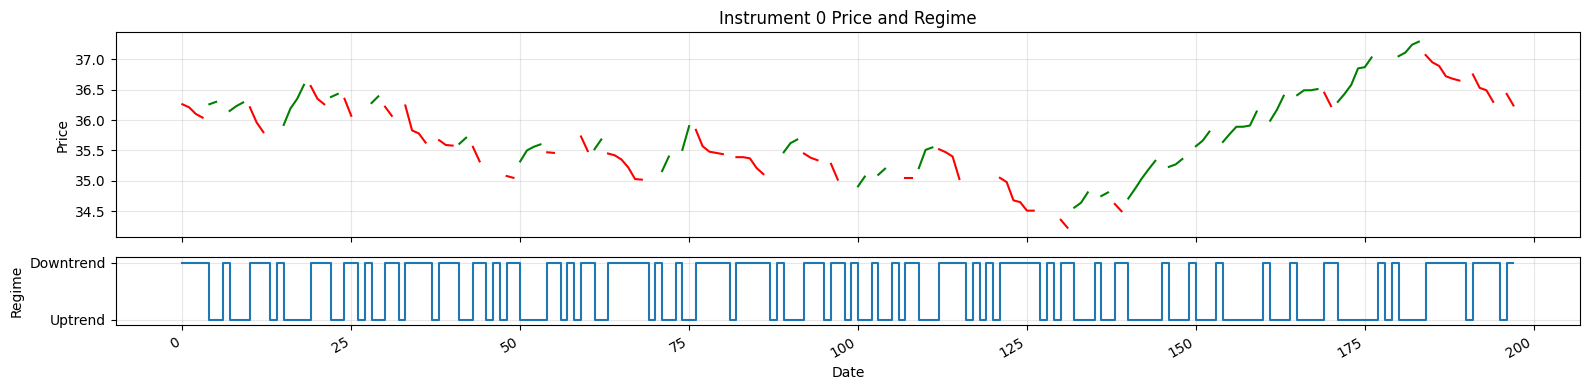

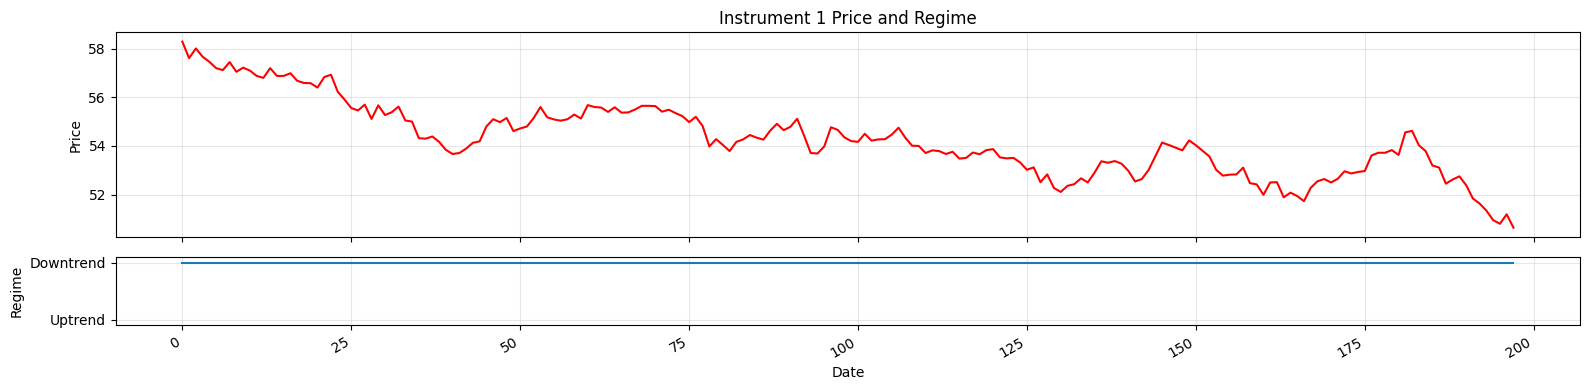

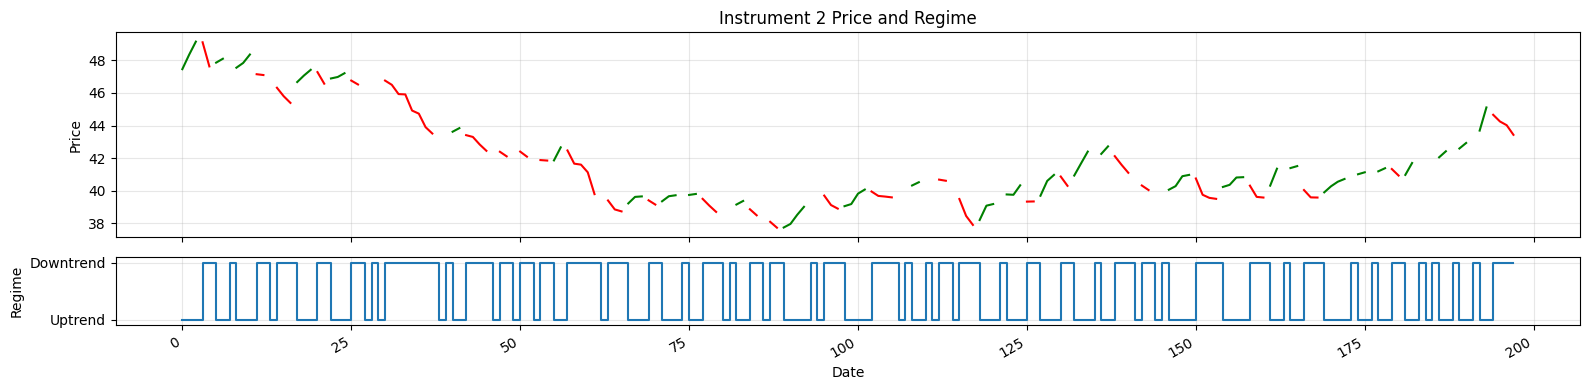

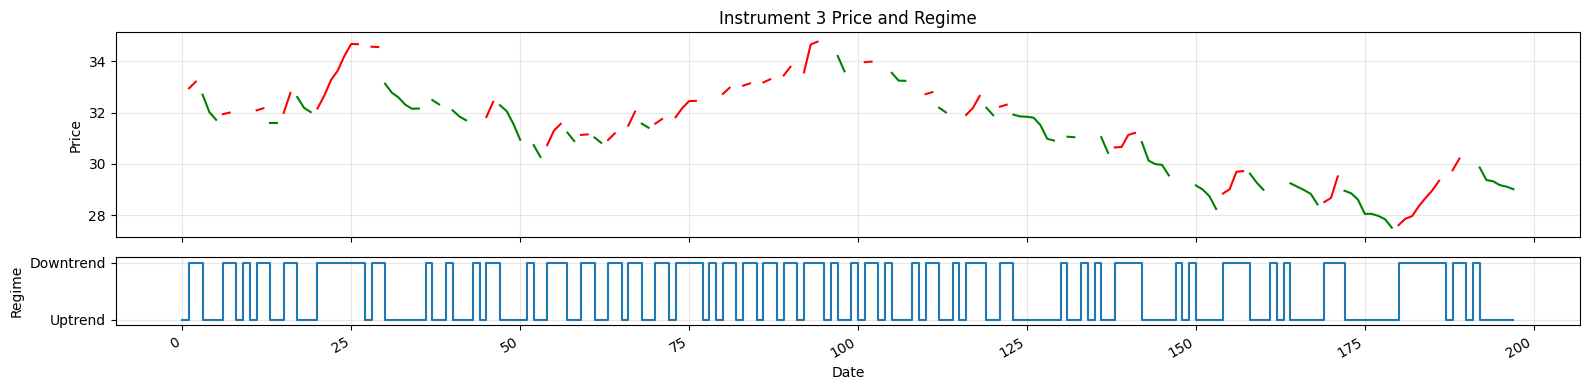

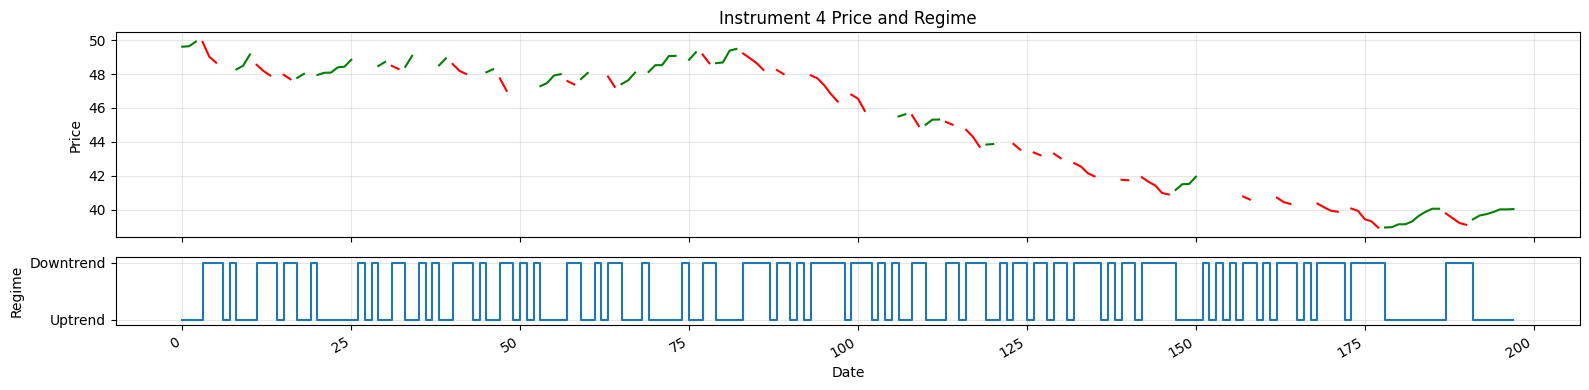

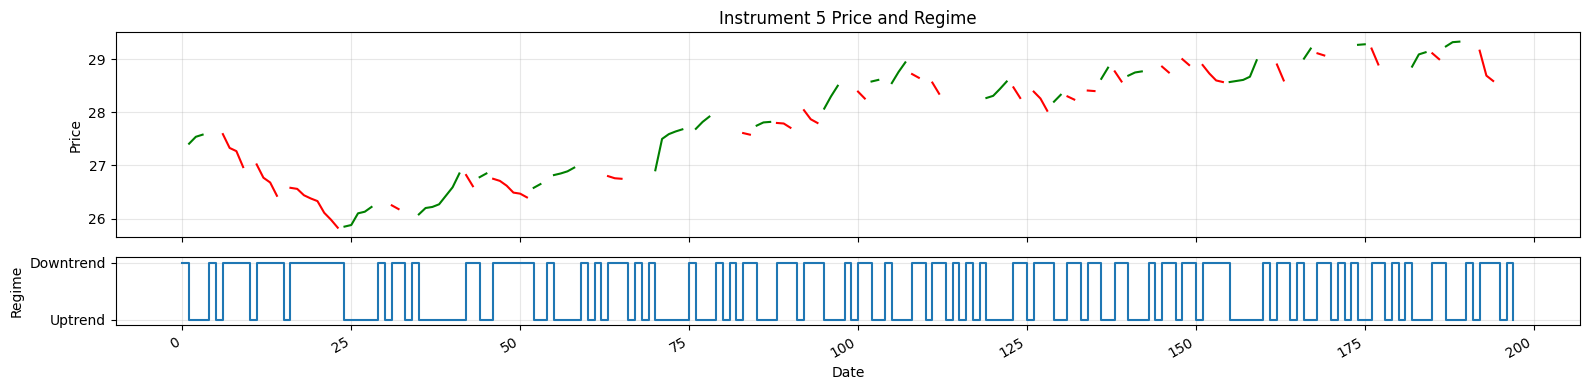

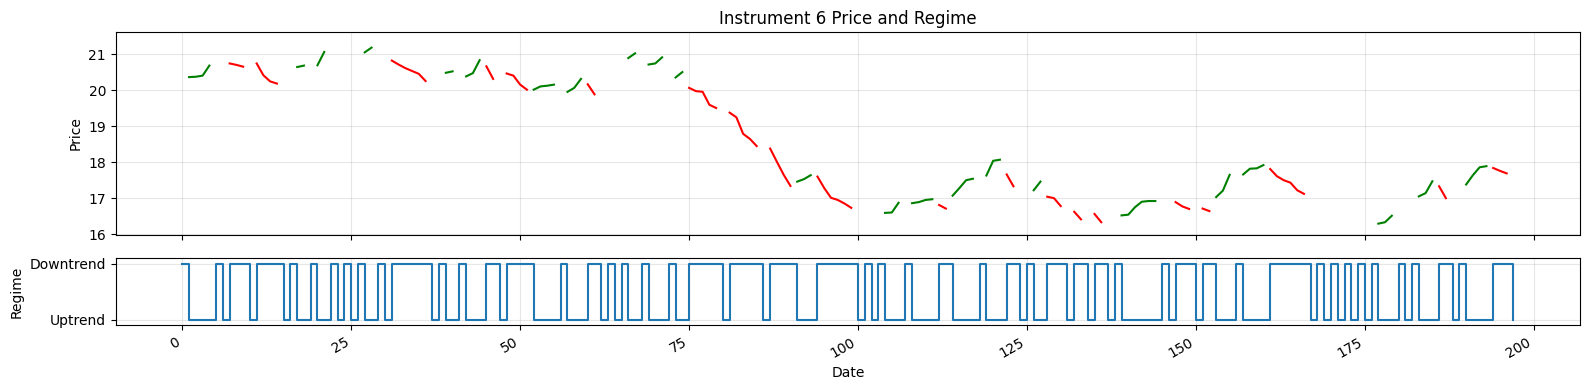

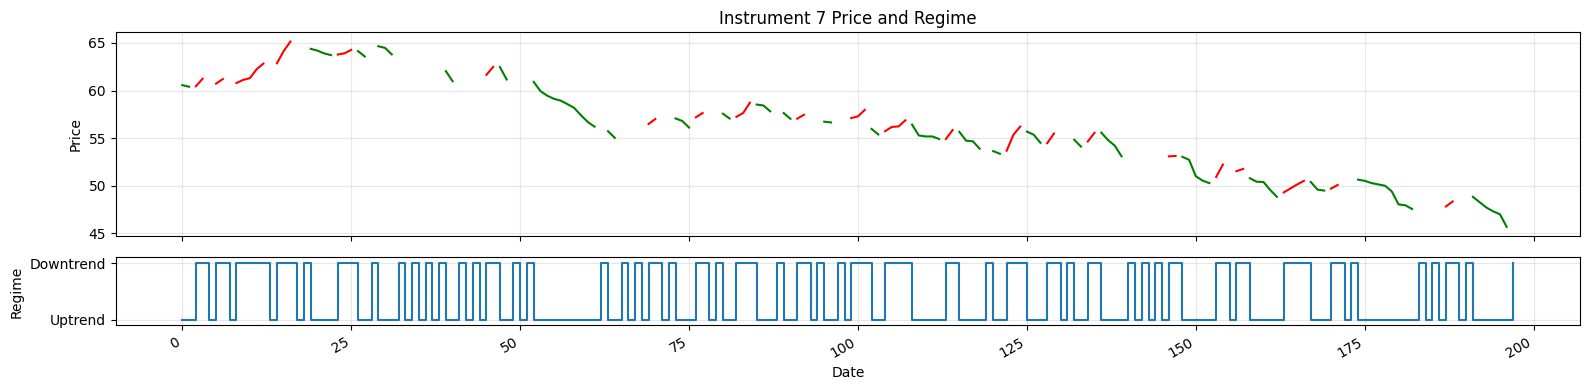

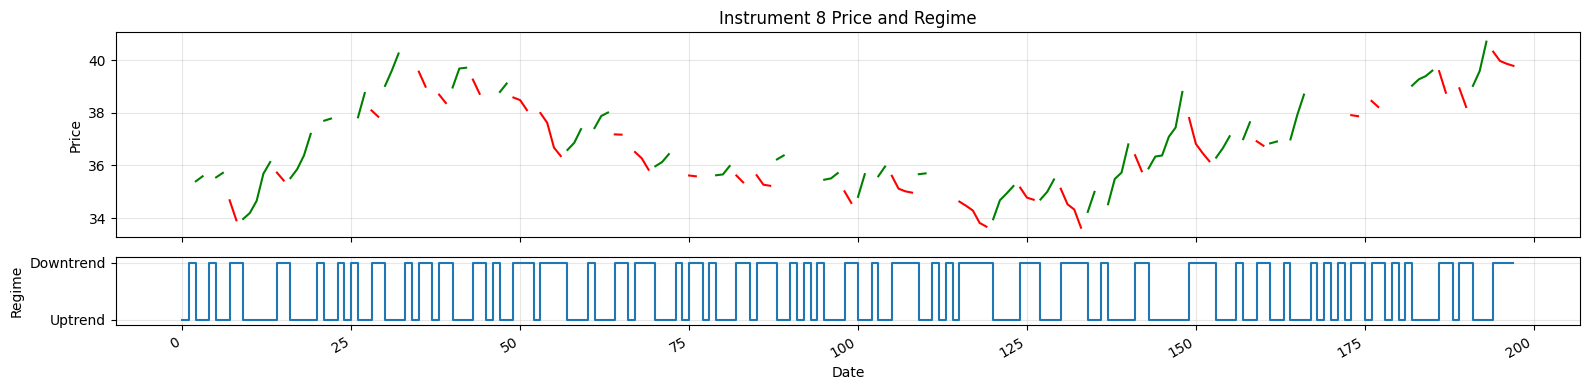

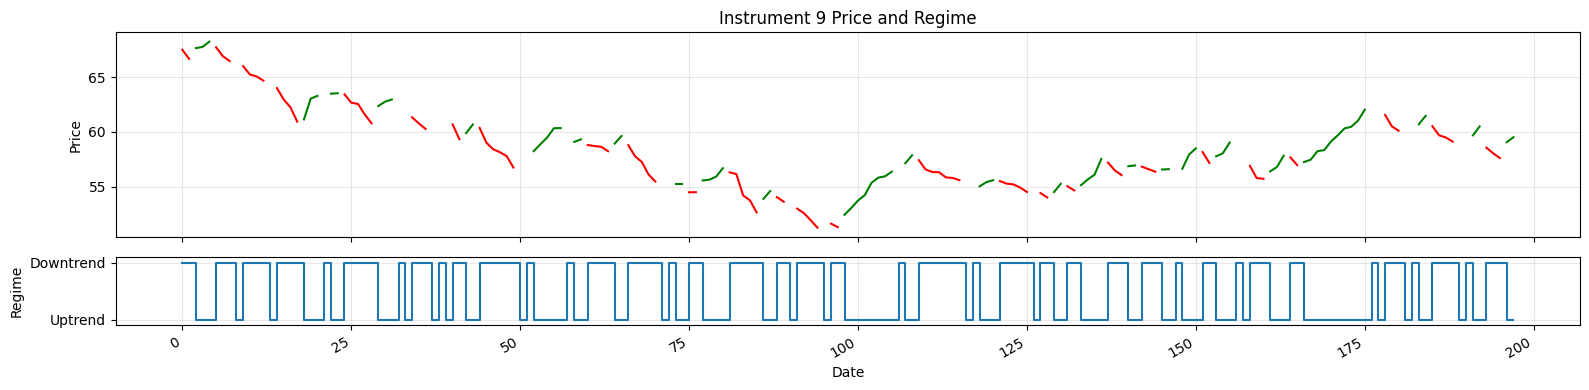

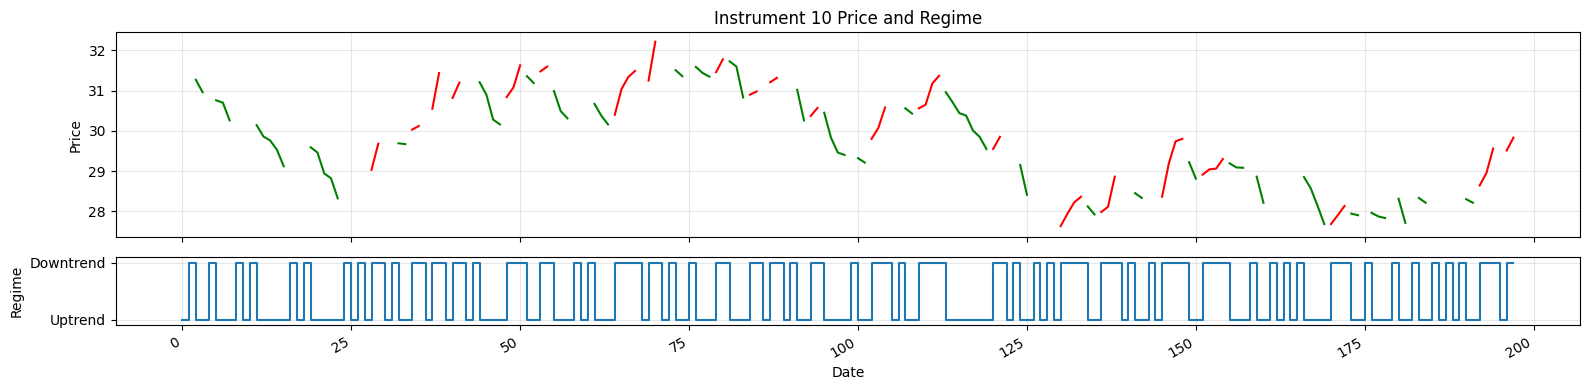

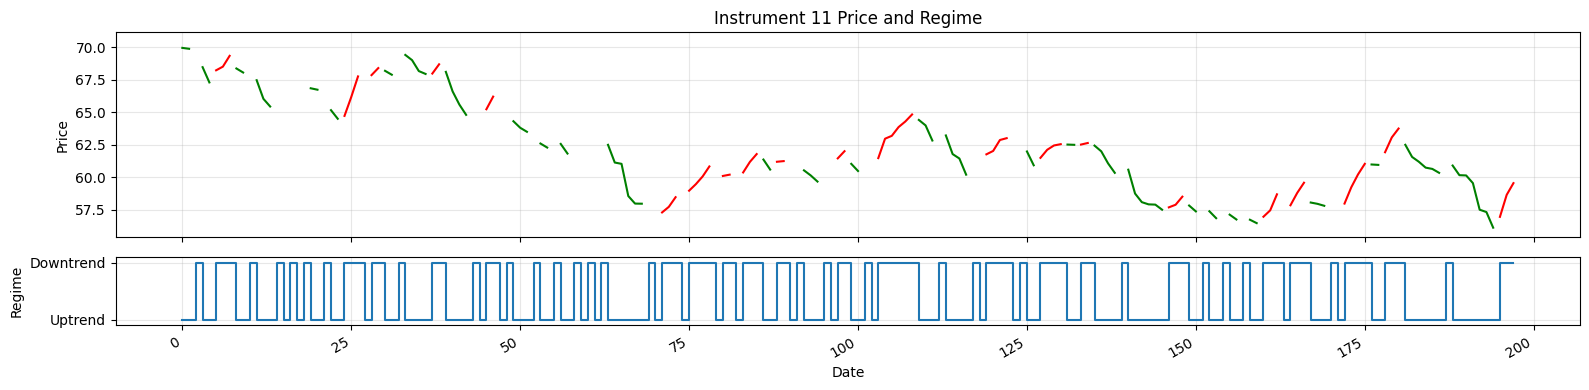

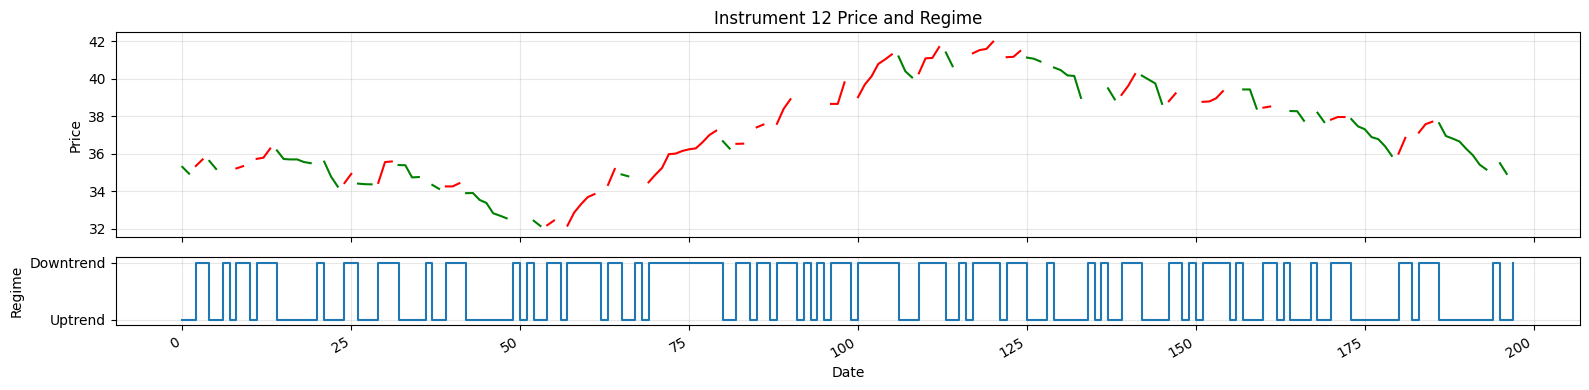

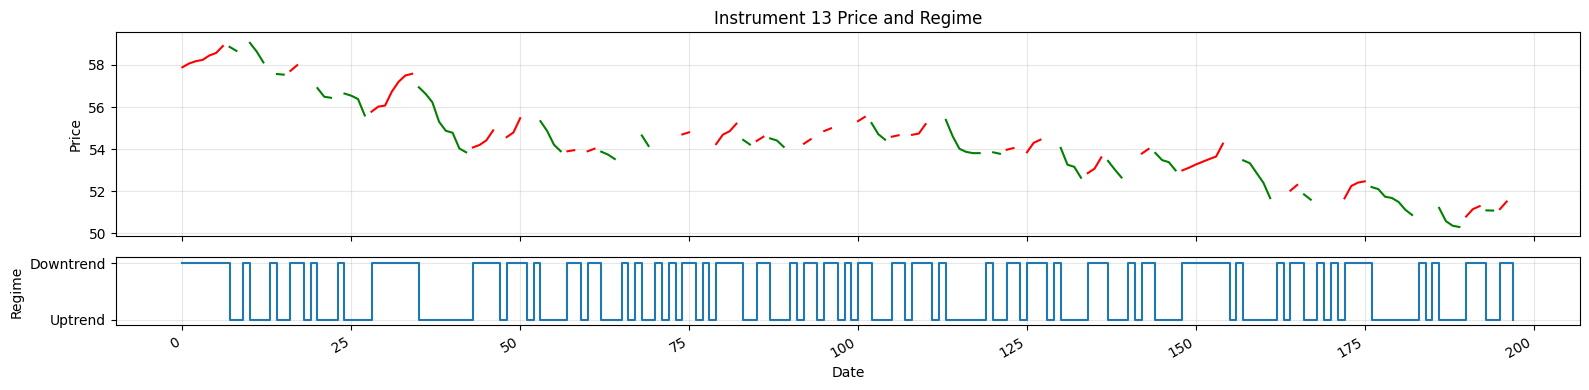

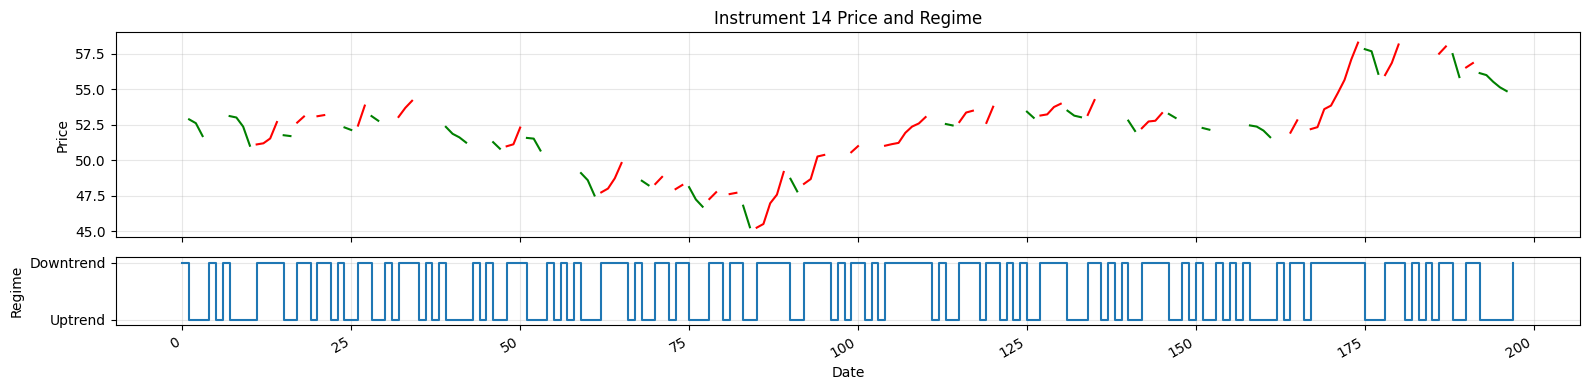

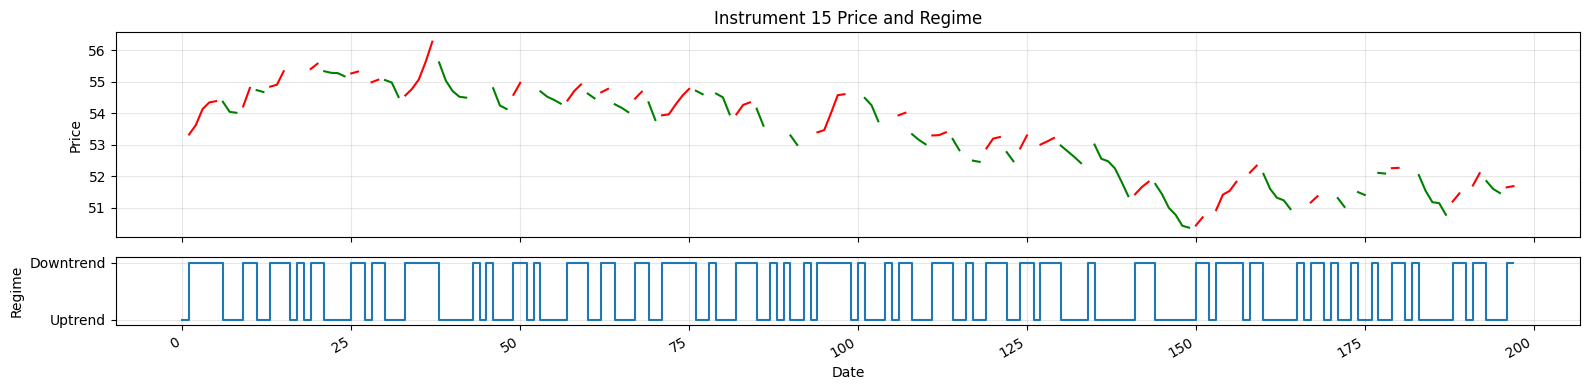

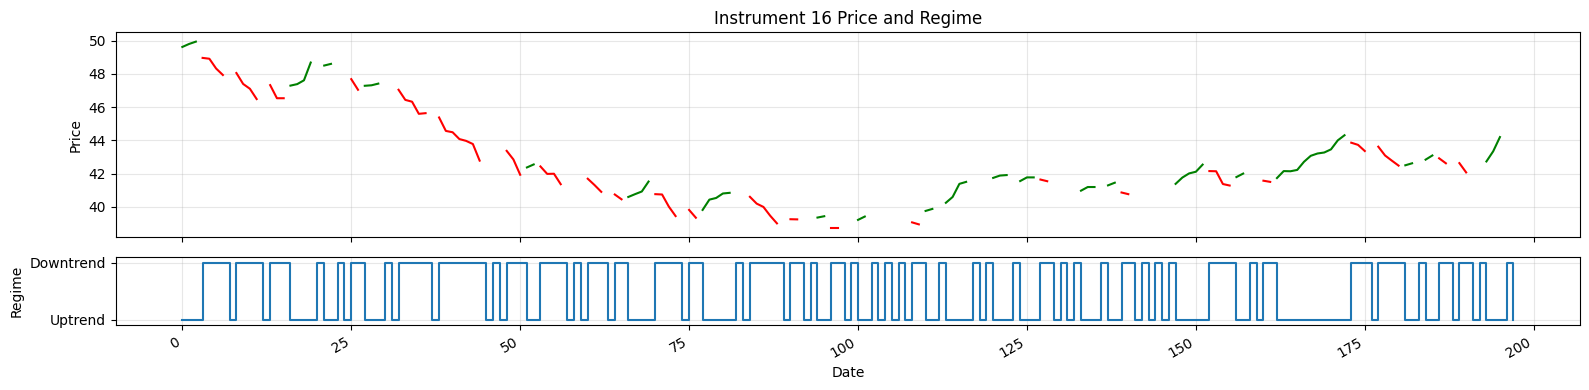

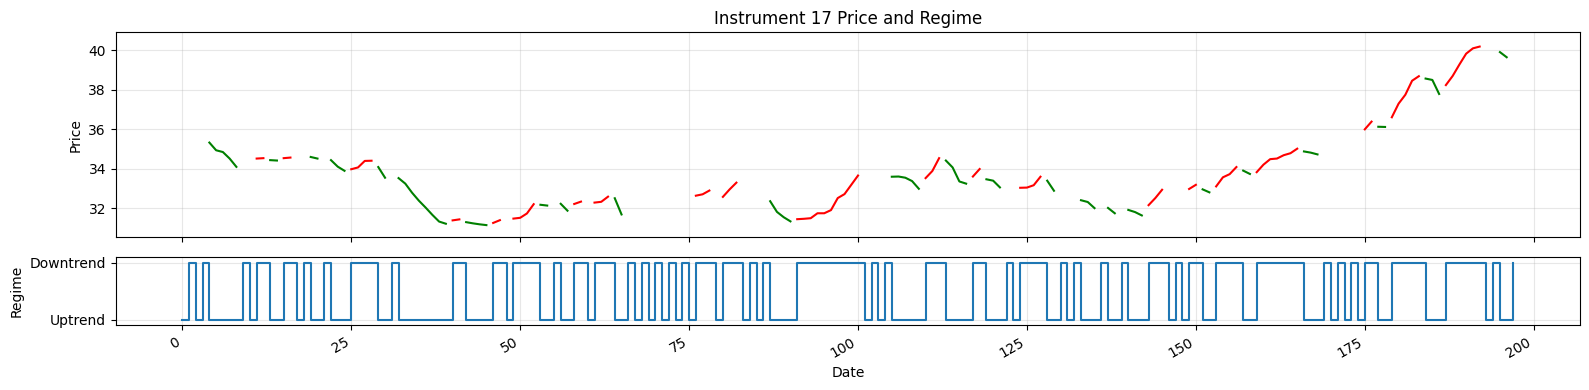

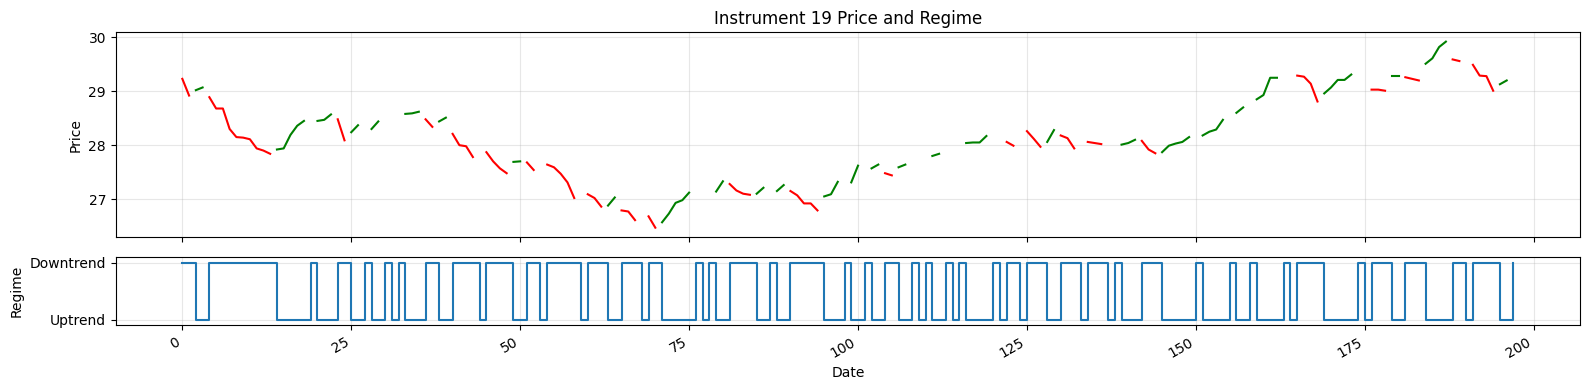

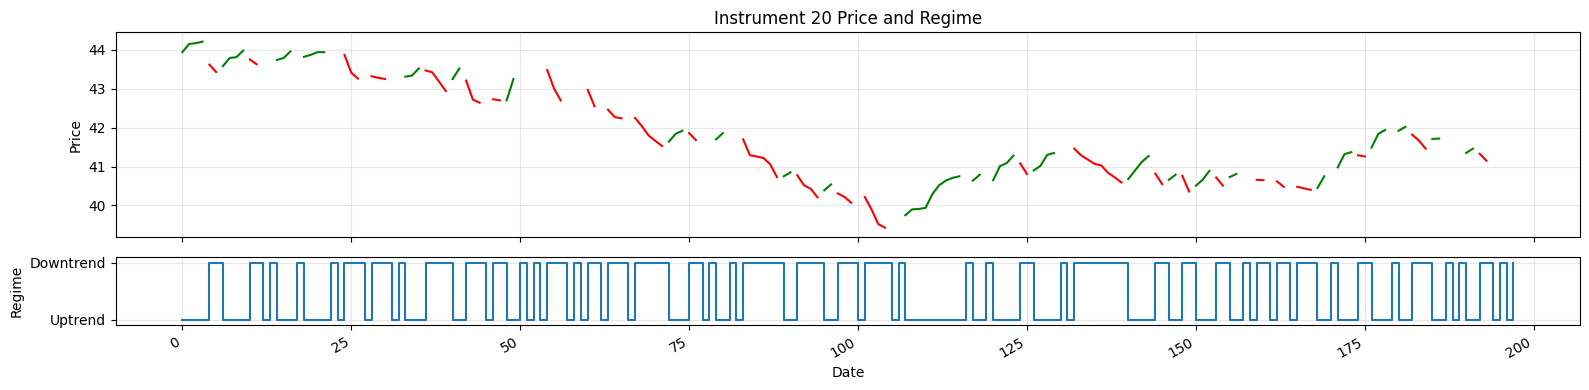

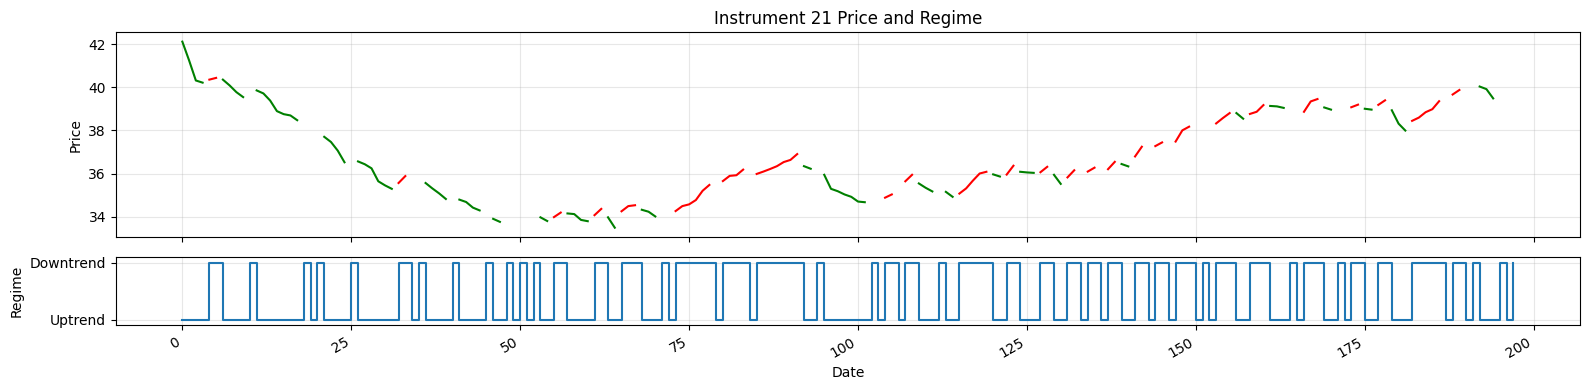

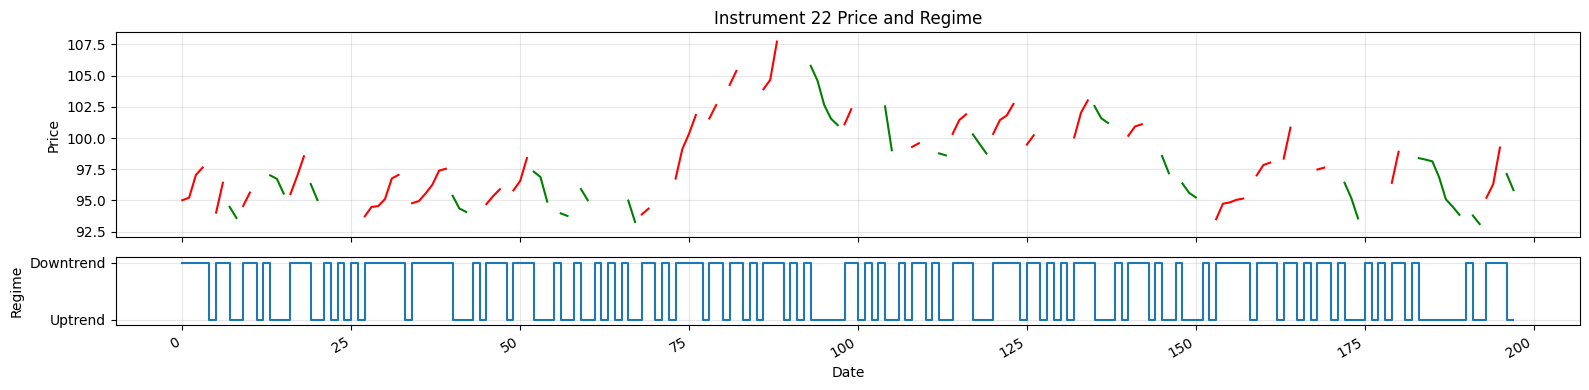

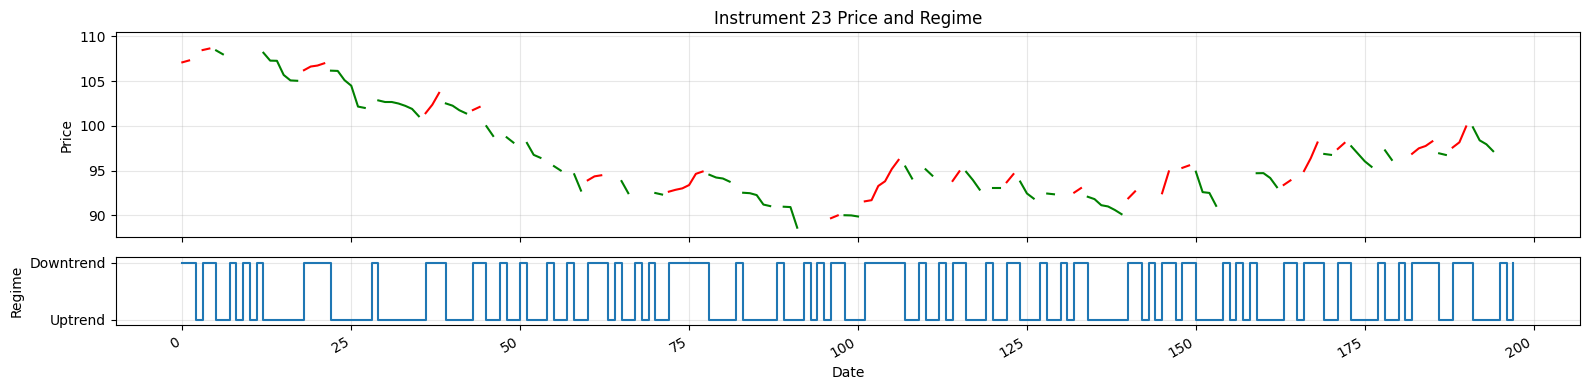

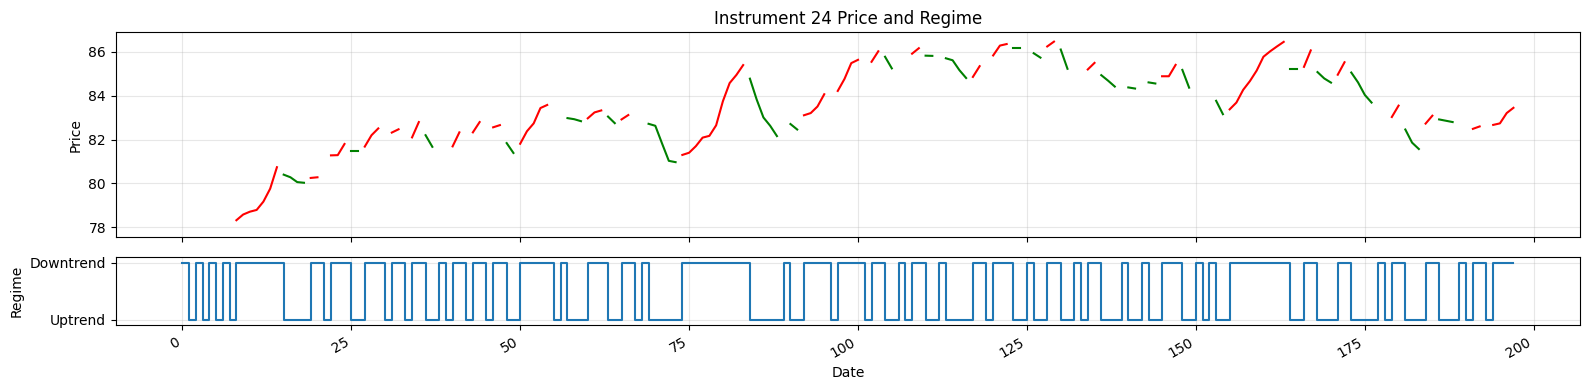

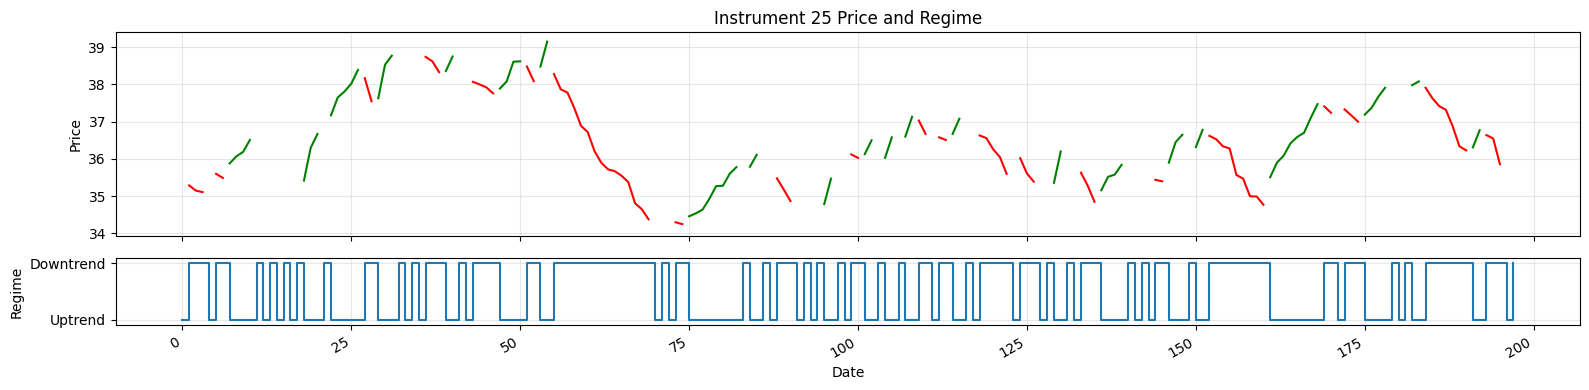

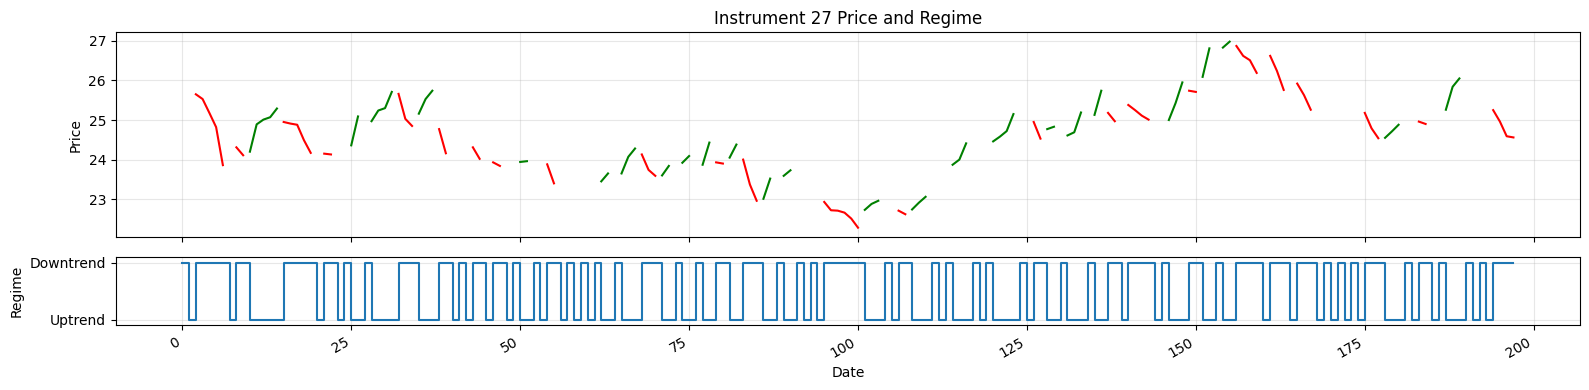

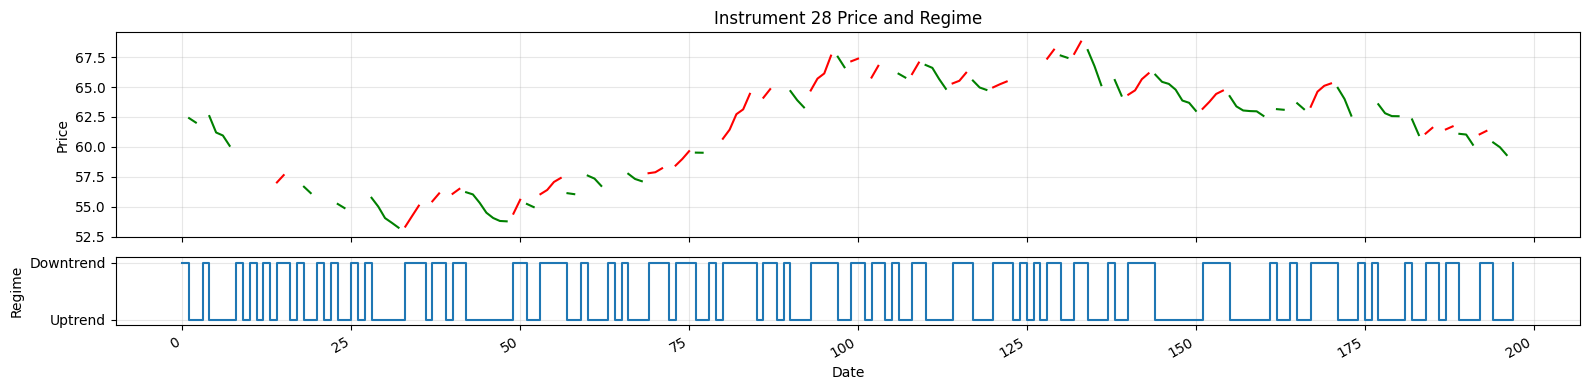

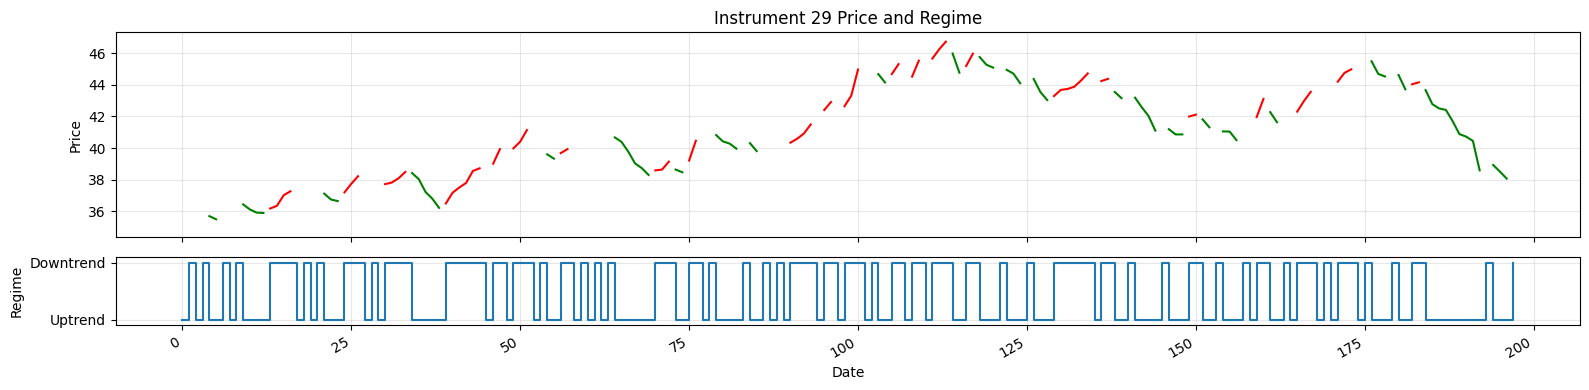

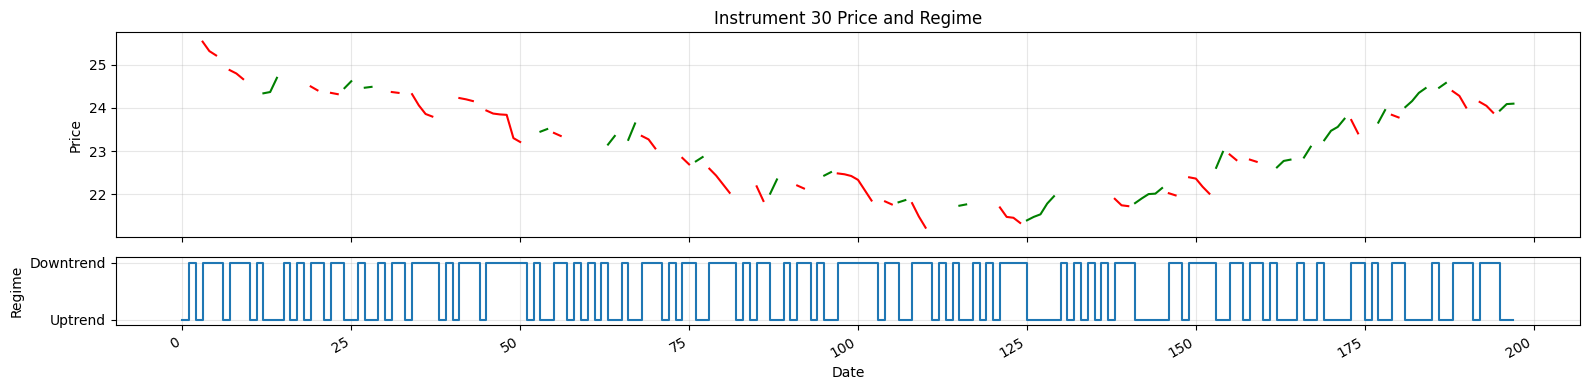

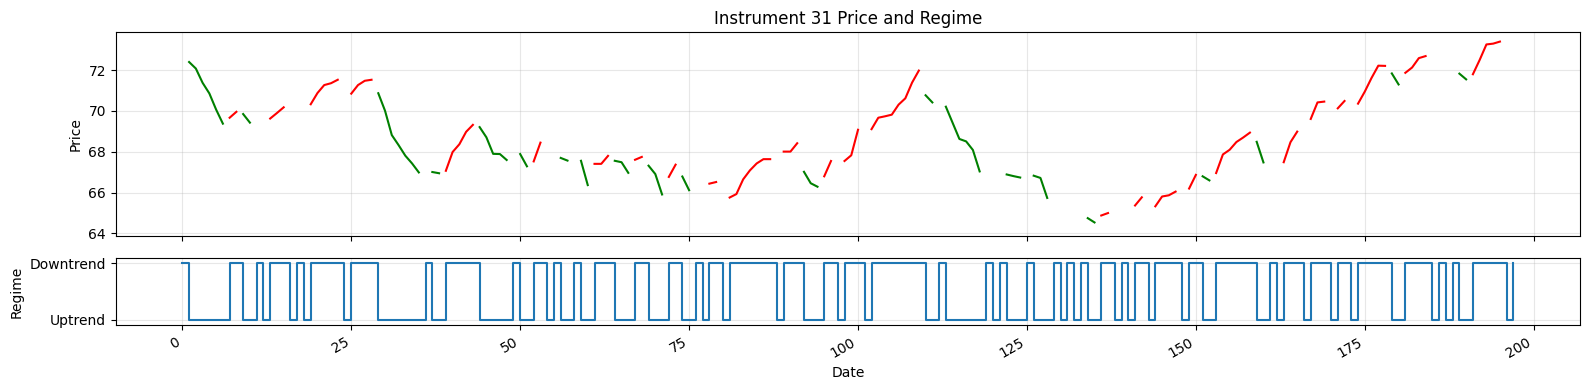

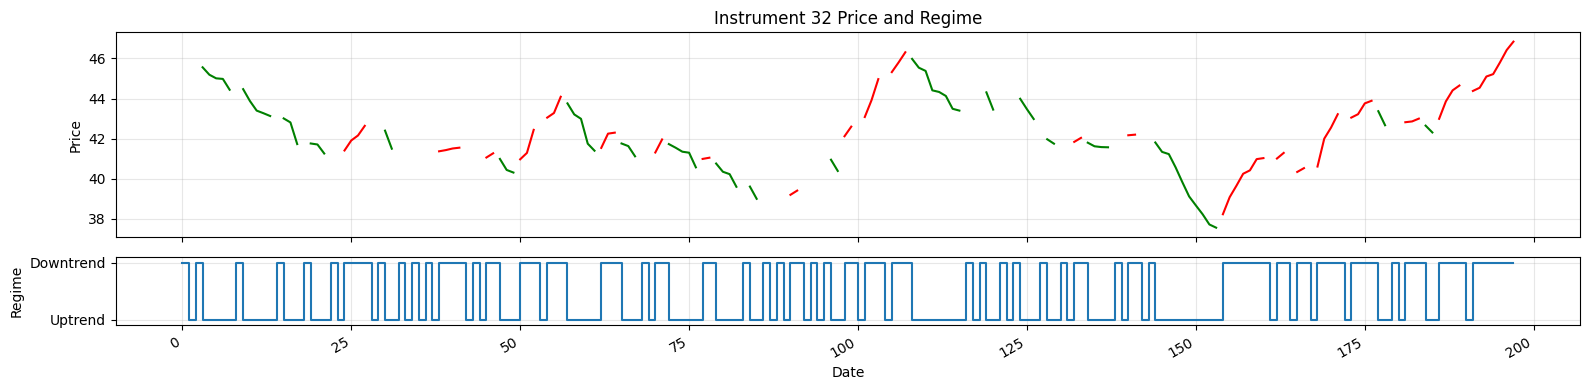

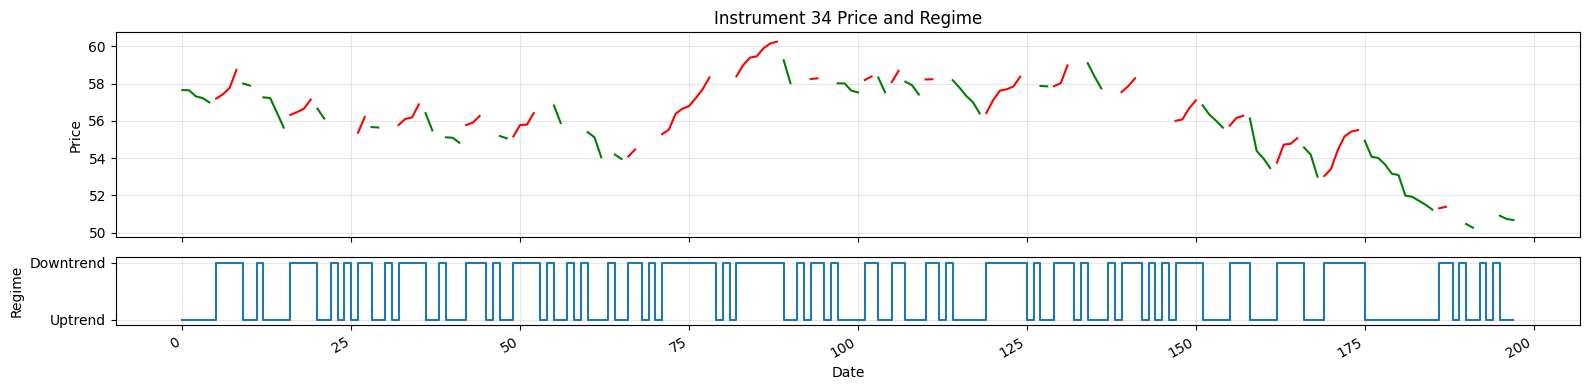

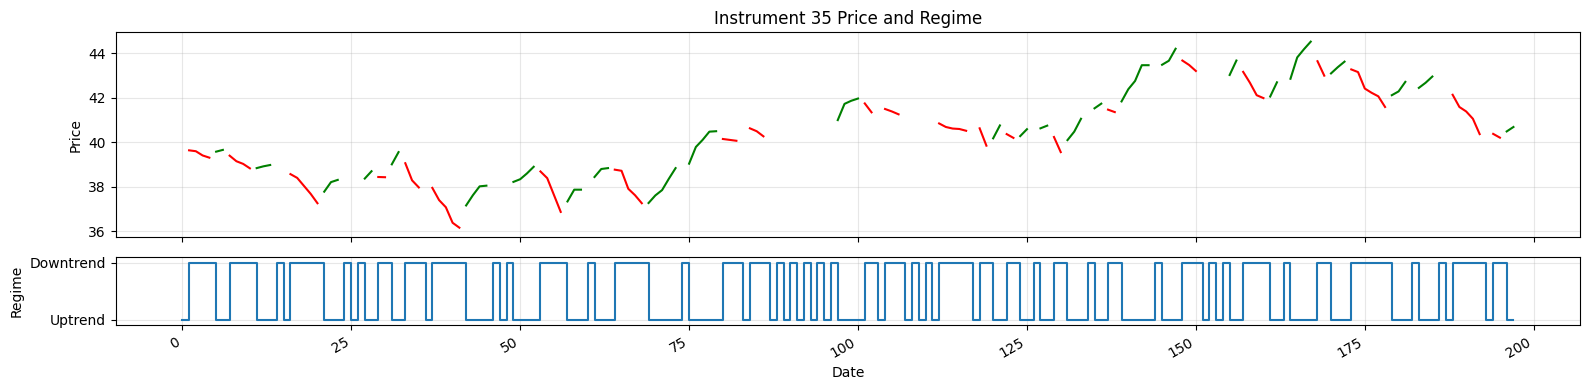

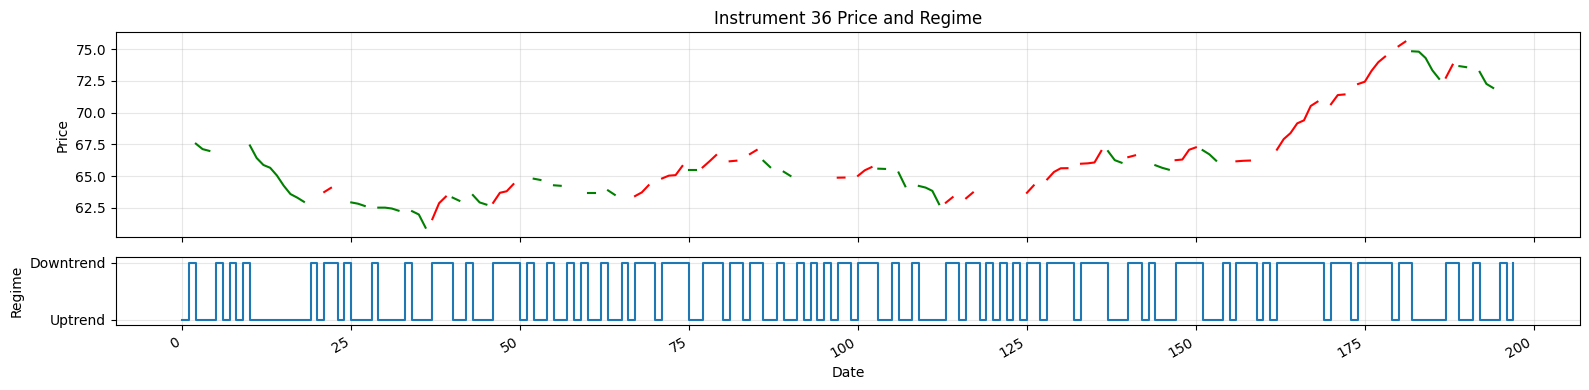

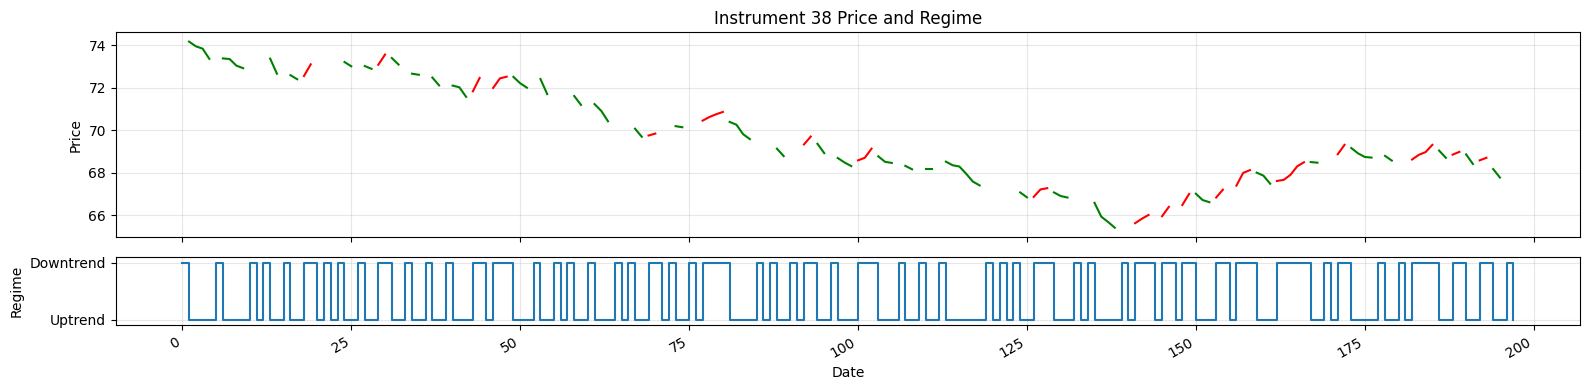

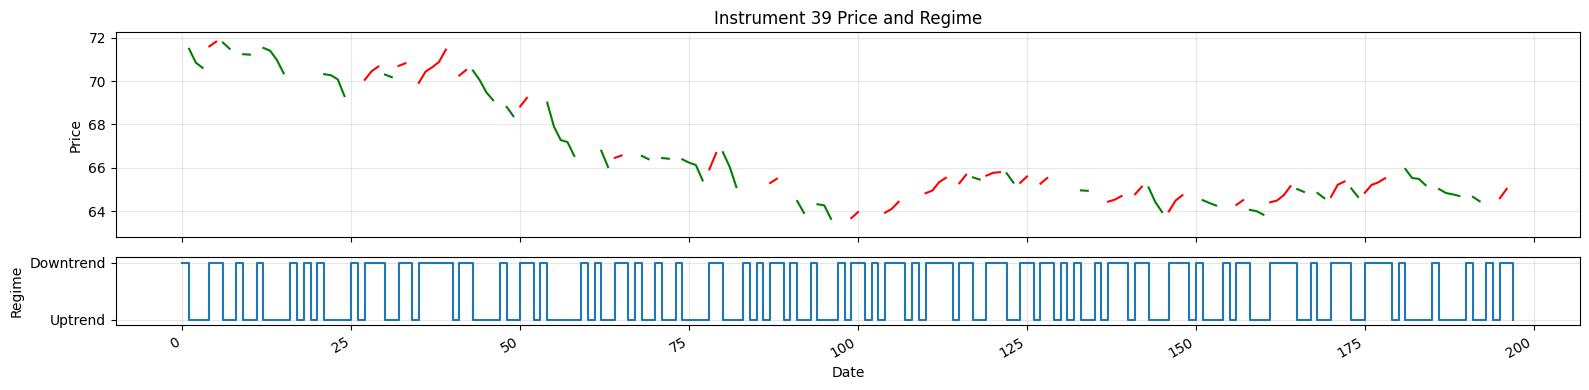

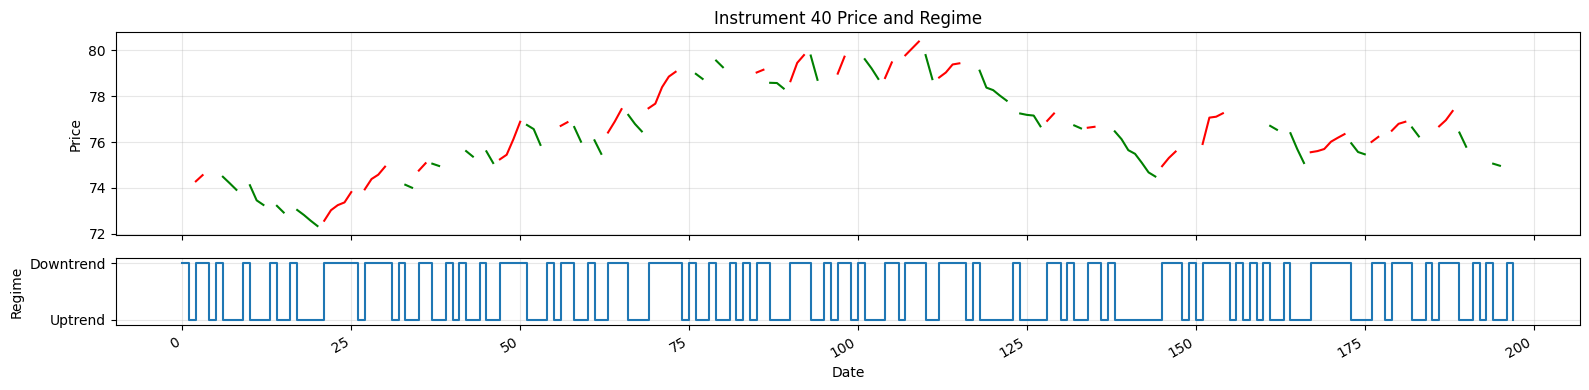

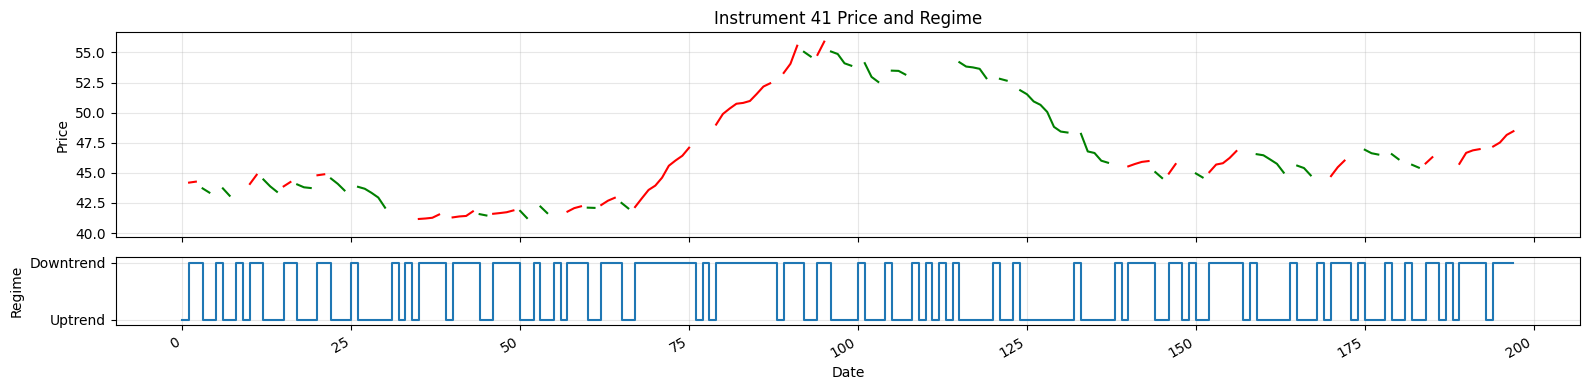

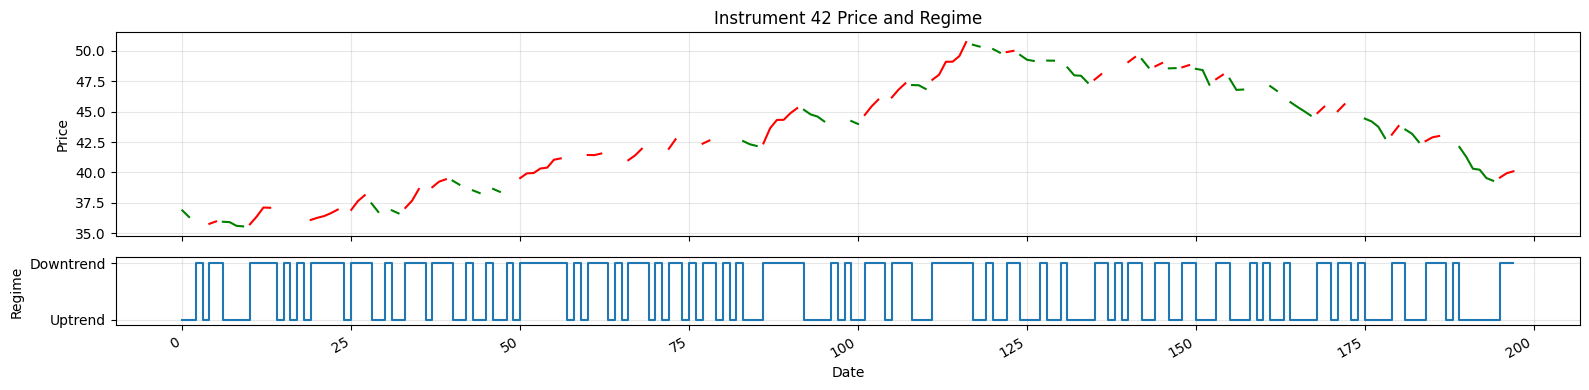

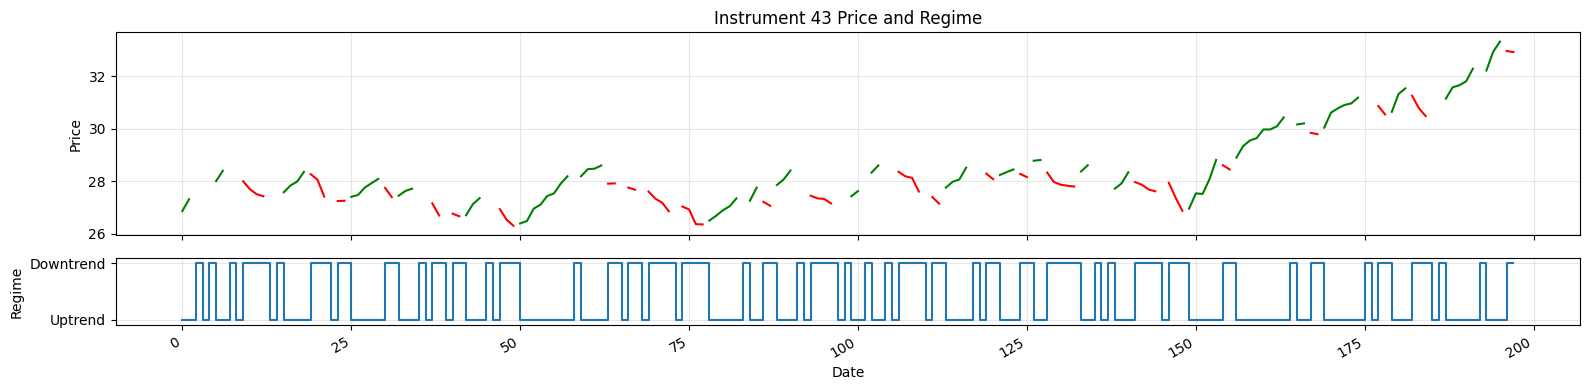

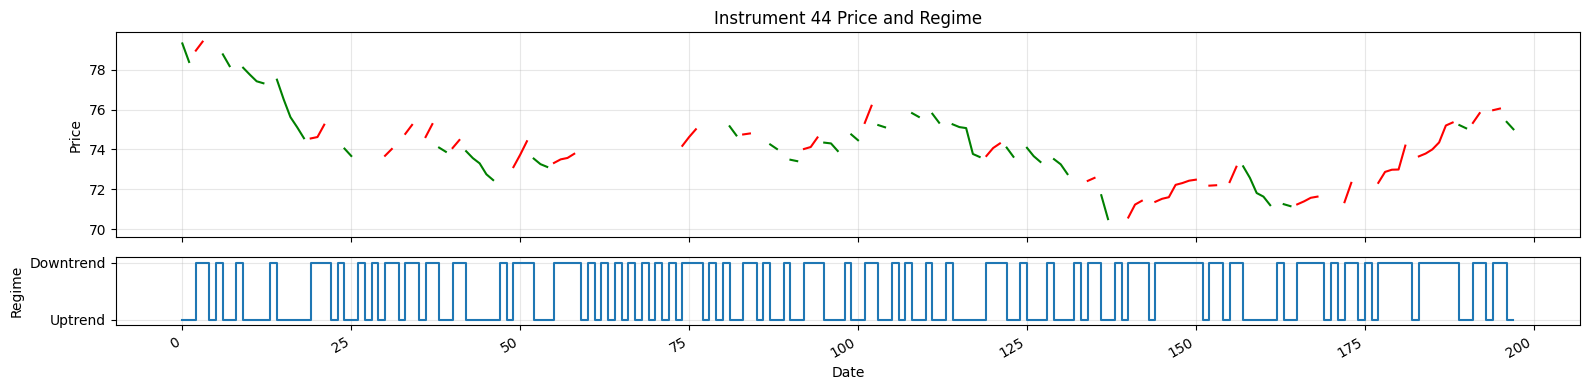

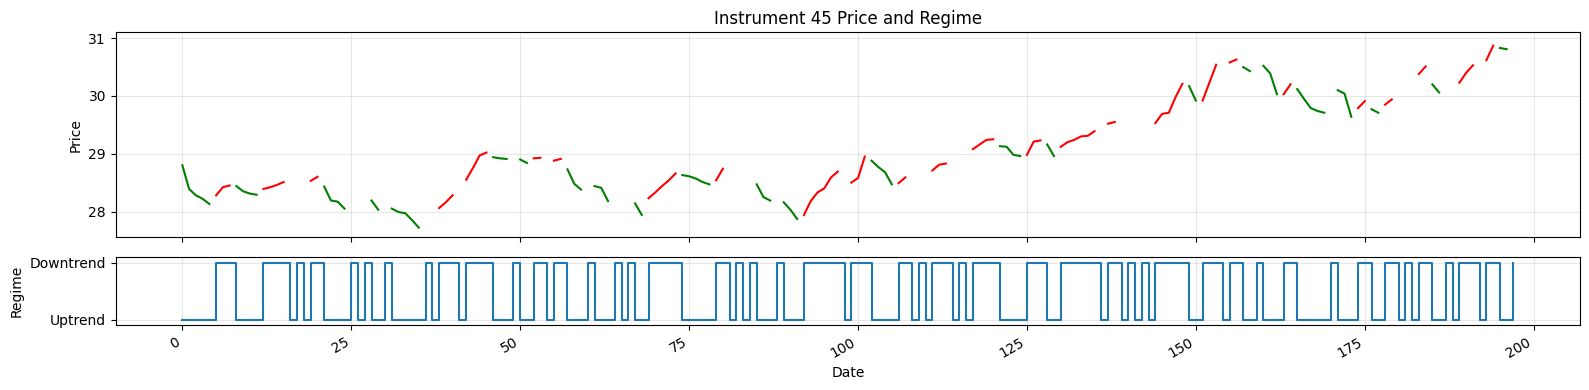

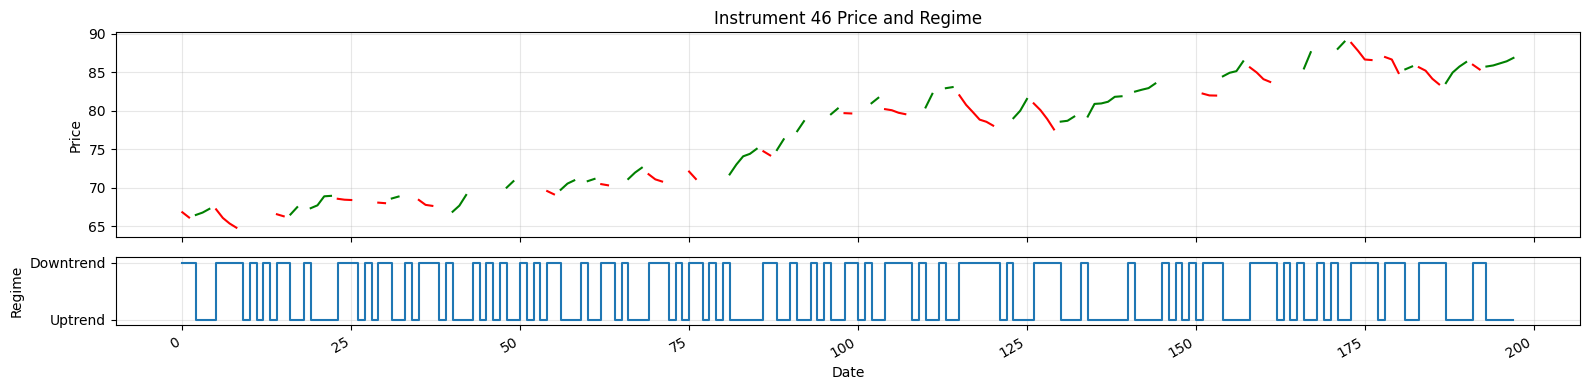

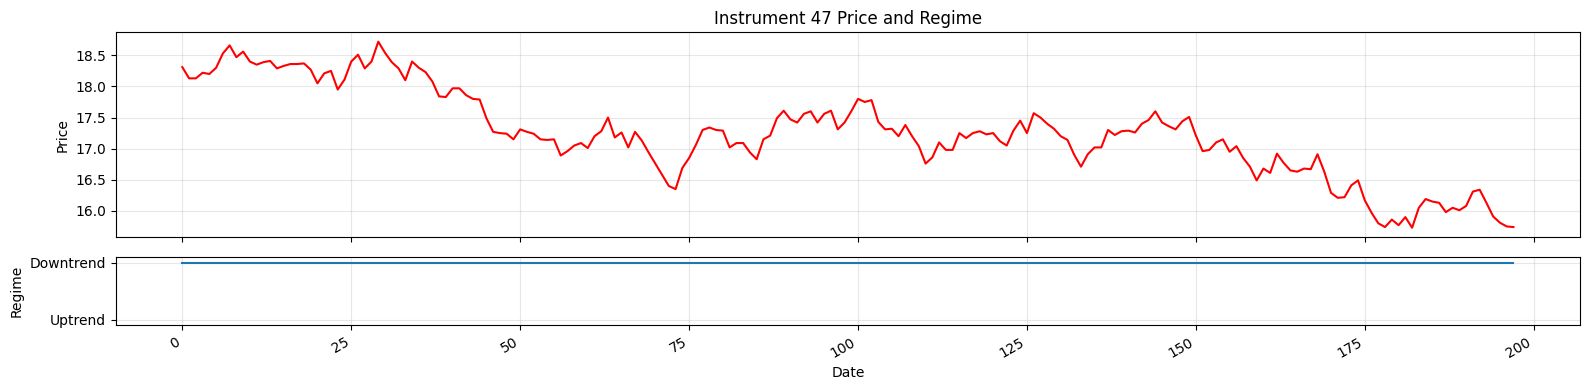

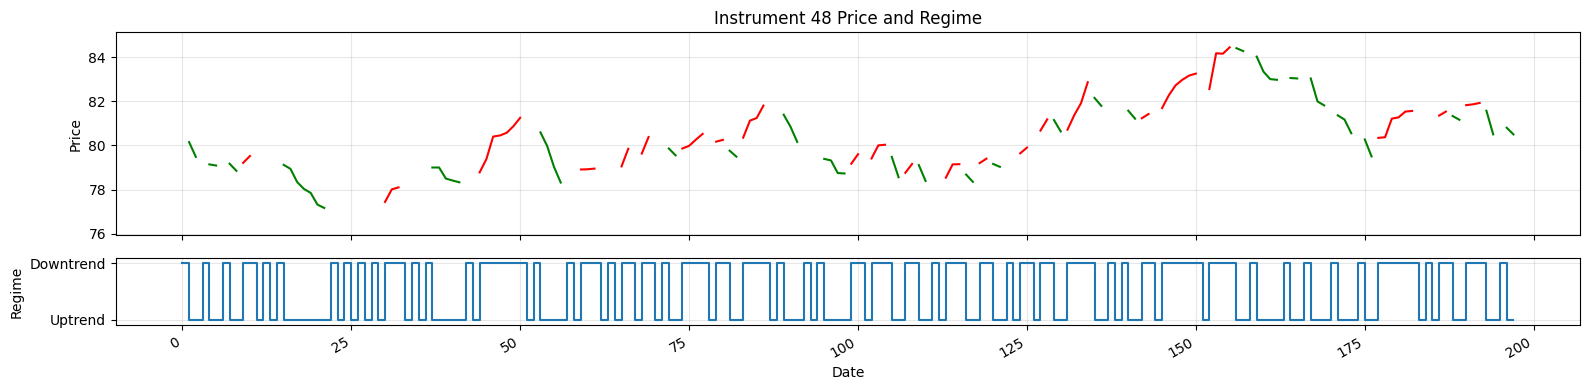

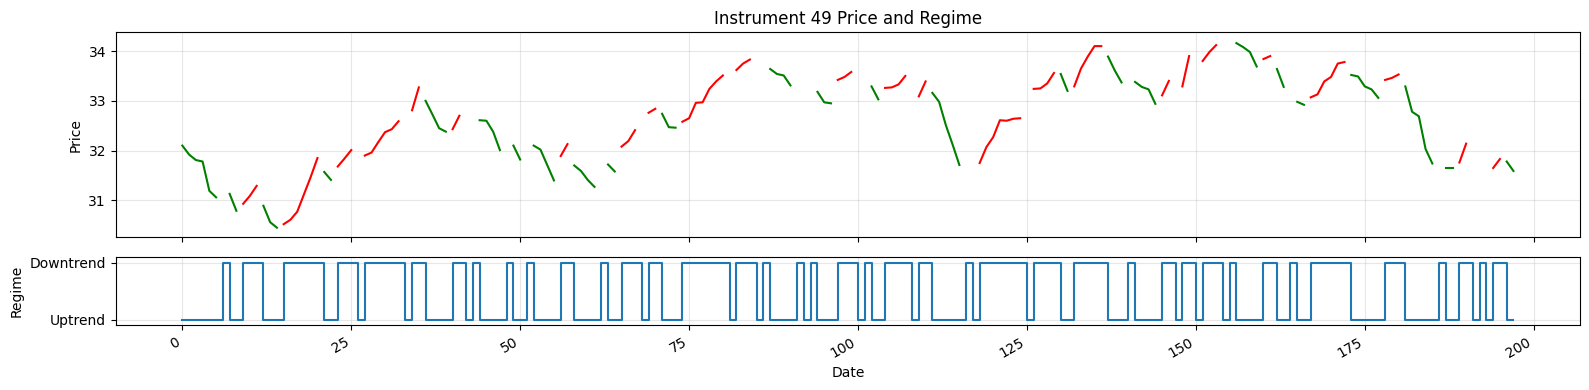

In [97]:
def get_out_of_sample_data(data: Dict[int, DataFrame], start_index, end_index, models: Dict[int,
	any]) -> Dict[int, DataFrame]:
	out_of_sample_data: Dict[int, DataFrame] = {}
	raw_prices: DataFrame = pd.read_csv("../../prices.txt", sep=r"\s+", index_col=None, header=None)
	price_history: ndarray = raw_prices.values[start_index:end_index][:].T

	for instrument_no in data:
		out_of_sample_data[instrument_no] = pd.DataFrame(columns=["price"])
		out_of_sample_data[instrument_no]["price"] = price_history[instrument_no]
		out_of_sample_data[instrument_no]["returns"] = (out_of_sample_data[instrument_no]["price"]
														.diff().dropna())

		# Clip data
		out_of_sample_data[instrument_no] = (out_of_sample_data[instrument_no].iloc[1:].reset_index
												 (drop=True))

		res = models[instrument_no]

		full_returns = pd.concat([data[instrument_no]["returns"],
								  out_of_sample_data[instrument_no]["returns"]], ignore_index=True)

		# 2. Re-create the same model spec on the full data
		model_full = MarkovAutoregression(
			full_returns,
			k_regimes=res.model.k_regimes,
			order=res.model.order,
			switching_ar=res.model.switching_ar,
			switching_variance=res.model.switching_variance
		)

		filt_res = model_full.filter(res.params)
		n_train = len(sample_data[instrument_no])
		probs = filt_res.filtered_marginal_probabilities.iloc[n_train:]	
		
		# Clip data again
		out_of_sample_data[instrument_no] = (out_of_sample_data[instrument_no].iloc[1:].reset_index
													 (drop=True))
		
		out_of_sample_data[instrument_no]["predicted_regime"] = pd.Series(
				np.argmax(probs.values, axis=1),
				index=out_of_sample_data[instrument_no]["returns"].index
		)
		
	return out_of_sample_data


out_of_sample_data: Dict[int, DataFrame] = get_out_of_sample_data(sample_data, 550, 750, models)
out_of_sample_data = generate_signals(out_of_sample_data)
out_of_sample_data = get_strategy_results(out_of_sample_data)
show_performance_metrics(out_of_sample_data)
plot_price_and_regime(out_of_sample_data)